In [1]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import default_style

# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

font sizes set


In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,1st,actor_1,M
1,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
3,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
4,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [3]:
TARGET_COLUMN = 'emotional_intensity'
values = df[TARGET_COLUMN].unique().tolist()
values

['normal', 'strong']

# Dataset preparation

In [4]:
try:
    excluded_prefixes = ['zc']
    columns_to_remove = []
    for column in df[numerical_attr_list].columns:
        if column.startswith(tuple(excluded_prefixes)) or column == TARGET_COLUMN:
            columns_to_remove.append(column)

    columns_to_remove;
    df = df.drop(columns=columns_to_remove, axis=1)
    
except KeyError as e:
    print(e)
    
for col in columns_to_remove:
    try:
        print(col)
        numerical_attr_list.remove(col)
    except ValueError as e:
        print(e, f"raised by column '{col}'")
        

zc_sum
zc_mean
zc_std
zc_kur
zc_skew
zc_mean_w1
zc_sum_w2
zc_skew_w2
zc_sum_w3
zc_kur_w3
zc_sum_w4
zc_mean_w4


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
scaler = MinMaxScaler()
X = scaler.fit_transform(df[numerical_attr_list])

label_enc = LabelEncoder()
y = label_enc.fit_transform(df[TARGET_COLUMN])

# print(f"numerical_attr_list is {numerical_attr_list}")
print(f"target variable: {np.unique(y, return_counts=True)}")
print(f"X has shape {X.shape}")

target variable: (array([0, 1]), array([1310, 1119]))
X has shape (2429, 231)


In [6]:
from sklearn.model_selection import train_test_split

# Divide in train, test, validation
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
test_mask = df.actor_number >= 19
df.drop(columns="actor_number", inplace=True)

X_test, y_test = X[test_mask], y[test_mask]

X_train, X_val, y_train, y_val = train_test_split(X[~test_mask], y[~test_mask], test_size=0.2)
print(f"Train: {X_train.shape}\nVal: {X_val.shape}\nTest: {X_test.shape}")

Train: (1450, 231)
Val: (363, 231)
Test: (616, 231)


### Default plots

In [7]:
# Shows the decision boundaries in the embedding
def boundaries_on_embedding(reducer, predictor, 
                            plot_function="predict", levels=None, linewidths=1.5,
                            embedding=None, n_pts=30,
                            ax=None, subsamp_fraction=0.5,
                            **kwargs):
    
    global X, y, X_train, X_test,X_val, y_train, y_test, y_val
    cmap, title = kwargs.get("cmap", "viridis"), kwargs.get("title", "Decision boundaries on embedding")
    
    edges_color = (0.2, 0.2, 0.2)
    edges_color_neg = (0.8, 0.8, 0.8)
    
    if embedding is None:
        embedding =  reducer.fit_transform(X)
        
    if ax is None:
        fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
        
    if levels is None:
        levels=len(np.unique(y))-1
        
    # Generate a grid in embedding
    xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), n_pts)
    yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), n_pts)

    XX, YY = np.meshgrid(xx, yy)
    points_in_embedding = np.array(np.meshgrid(xx, yy)).T
    old_shape = points_in_embedding.shape[:-1]
    
    # Maps them back in the big space
    points_in_embedding = points_in_embedding.reshape(-1,2)
    points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

    # Gets results
    plotting_function = getattr(predictor, plot_function)
    results = plotting_function(points_in_gigaspace).reshape(old_shape)
    plt.contourf(XX, YY, results.T, cmap=cmap, alpha=0.6, levels=levels)
    
    
    # Plots the scatter
    subsamp = np.random.uniform(0,1, size=len(test_mask)) < subsamp_fraction
    plt.scatter(*embedding[(~test_mask)&(subsamp)].T, c=y[(~test_mask)&(subsamp)], 
                marker="o", 
                edgecolor=None,  
                s=7, 
                cmap=cmap,
                alpha=1,
                label="train+val")
    plt.scatter(*embedding[test_mask&subsamp].T, c=y[(test_mask)&(subsamp)], 
                marker="o", 
                edgecolor=edges_color, 
                s=7,
                cmap=cmap,
                alpha=1,
                label="test")
    
    # Plot contours without color
    plt.contour(XX, YY, results.T, alpha=1, 
                levels=levels, 
                colors=[edges_color, edges_color_neg],
                   linewidths=linewidths)

    plt.legend()
    plt.axis("off");
    plt.title(title);
    plt.savefig(f"images/{title.replace(' ', '_')}.pdf")

In [8]:
from sklearn.metrics import confusion_matrix

def plot_cfm(y_true, y_pred, title="Confusion matrix", cmap="Greens"):
    fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
    cf = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf, annot=True, cmap=cmap, fmt=".4g", cbar=False, ax=ax, vmin=0)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(title)

    ticks = np.unique(y_true)
    ax.set_xticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
    ax.set_yticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
    ax.set_aspect("equal")
    plt.savefig(f"images/{title.replace(' ', '_')}.pdf")

### Select and embedding

In [9]:
# from sklearn.decomposition import PCA

# reducer = PCA(n_components=2)
# embedding = reducer.fit_transform(X)

from umap import UMAP

reducer = UMAP(n_neighbors=20)
embedding = reducer.fit_transform(X)
embedding_name = "UMAP"

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualen

In [10]:
# Some properties
N_PTS = 80
CMAP = "Spectral"
CMAP_CFM = "RdGy_r"

# Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import optuna

# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['none', 'elasticnet', 'l1', 'l2'])
    C = trial.suggest_float('C', 0.001,10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg',  'sag', 'saga'])

    logr = LogisticRegression(solver=solver, penalty=penalty, C=C)

    logr.fit(X_train, y_train)
    y_pred = logr.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError, TypeError))

[I 2023-07-09 11:33:33,823] A new study created in memory with name: no-name-be214e55-cc26-4aea-bd7f-f462d8dfa353
[W 2023-07-09 11:33:33,837] Trial 2 failed with parameters: {'penalty': 'none', 'C': 3.0088510149362047, 'solver': 'liblinear'} because of the following error: ValueError("penalty='none' is not supported for the liblinear solver").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 71, 

[W 2023-07-09 11:33:35,144] Trial 10 failed with parameters: {'penalty': 'l1', 'C': 7.083916274658704, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[W 2023-07-09 11:33:36,940] Trial 17 failed with value None.
[I 2023-07-09 11:33:36,943] Trial 7 finished with value: 0.7300275482093664 and parameters: {'penalty': 'l2', 'C': 6.494186250556901, 'solver': 'saga'}. Best is trial 16 with value: 0.7327823691460055.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-07-09 11:33:37,474] Trial 15 finished with value: 0.721763085399449 and parameters: {'penalty': 'l2', 'C': 6.661523265366716, 'solver': 'sag'}. Best is trial 16 with value: 0.7327823691460055.
[W 2023-07-09 11:33:37,525] Trial 20 failed with parameters: {'penalty': 'elasticnet', 'C': 9.78217933901929, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.l

[W 2023-07-09 11:33:37,834] Trial 26 failed with value None.
[W 2023-07-09 11:33:37,880] Trial 27 failed with parameters: {'penalty': 'l1', 'C': 9.257321267595477, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(


[W 2023-07-09 11:33:38,367] Trial 34 failed with value None.
[W 2023-07-09 11:33:38,408] Trial 35 failed with parameters: {'penalty': 'l1', 'C': 9.96923847182741, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
V

[W 2023-07-09 11:33:39,954] Trial 43 failed with value None.
[W 2023-07-09 11:33:40,016] Trial 44 failed with parameters: {'penalty': 'l1', 'C': 9.818691299336319, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(


[W 2023-07-09 11:33:40,522] Trial 51 failed with value None.
[W 2023-07-09 11:33:40,561] Trial 52 failed with parameters: {'penalty': 'l1', 'C': 9.192836396200951, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(


[W 2023-07-09 11:33:40,908] Trial 59 failed with value None.
[W 2023-07-09 11:33:40,942] Trial 60 failed with parameters: {'penalty': 'l1', 'C': 9.337537478335669, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(


[W 2023-07-09 11:33:41,316] Trial 67 failed with value None.
[W 2023-07-09 11:33:41,355] Trial 68 failed with parameters: {'penalty': 'l1', 'C': 9.97982111876426, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
V

[W 2023-07-09 11:33:41,831] Trial 75 failed with value None.
[W 2023-07-09 11:33:41,876] Trial 76 failed with parameters: {'penalty': 'l1', 'C': 8.65639824711042, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
V

[W 2023-07-09 11:33:42,276] Trial 83 failed with value None.
[W 2023-07-09 11:33:42,324] Trial 84 failed with parameters: {'penalty': 'l1', 'C': 9.815358781995938, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(


[W 2023-07-09 11:33:42,773] Trial 91 failed with value None.
[W 2023-07-09 11:33:42,886] Trial 92 failed with parameters: {'penalty': 'l1', 'C': 9.479515656922196, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(


[W 2023-07-09 11:33:43,367] Trial 99 failed with value None.
[W 2023-07-09 11:33:43,451] Trial 100 failed with parameters: {'penalty': 'l1', 'C': 9.214167366841334, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(

[W 2023-07-09 11:33:44,333] Trial 107 failed with value None.
[W 2023-07-09 11:33:44,382] Trial 108 failed with parameters: {'penalty': 'l1', 'C': 9.498472939915995, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError

[W 2023-07-09 11:33:44,820] Trial 115 failed with value None.
[W 2023-07-09 11:33:44,984] Trial 116 failed with parameters: {'penalty': 'l1', 'C': 9.990413201998855, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError

[W 2023-07-09 11:33:45,700] Trial 123 failed with value None.
[W 2023-07-09 11:33:45,766] Trial 124 failed with parameters: {'penalty': 'l1', 'C': 9.770723813229417, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError

[W 2023-07-09 11:33:46,147] Trial 131 failed with value None.
[W 2023-07-09 11:33:46,176] Trial 132 failed with parameters: {'penalty': 'l1', 'C': 4.590792348073306, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError

[W 2023-07-09 11:33:46,592] Trial 139 failed with value None.
[W 2023-07-09 11:33:46,656] Trial 140 failed with parameters: {'penalty': 'l1', 'C': 9.202455434716452, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError

[W 2023-07-09 11:33:47,209] Trial 147 failed with value None.
[W 2023-07-09 11:33:47,317] Trial 148 failed with parameters: {'penalty': 'l1', 'C': 9.826976080032653, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError

In [13]:
best_params = study.best_params
logr = LogisticRegression(**best_params)

# Trains on test AND validation
logr.fit(np.concatenate((X_train, X_val)), np.concatenate([y_train, y_val]))

y_pred_test = logr.predict(X_test)

from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 7.022062663655536, 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       332
           1       0.68      0.68      0.68       284

    accuracy                           0.70       616
   macro avg       0.70      0.70      0.70       616
weighted avg       0.70      0.70      0.70       616

Accuracy 0.702922077922078
F1-score [0.72481203 0.67724868]


choose liblinear solver beacause for small datasets is a good choice. 
The key difference between these l1(ridege) and l2(lasso) is that Lasso shrinks the less 
important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

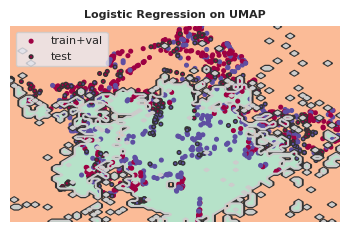

In [14]:
boundaries_on_embedding(reducer, logr, embedding=embedding, 
                        title=f"Logistic Regression on {embedding_name}", 
                        cmap="Spectral",
                        n_pts=N_PTS)

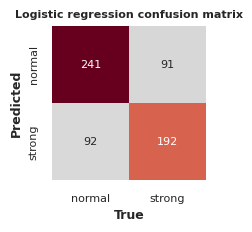

In [15]:
plot_cfm(y_test, y_pred_test, title="Logistic regression confusion matrix", cmap=CMAP_CFM)

# Support Vector Machine

## Linear SVM

In [16]:
from sklearn.svm import LinearSVC

In [17]:
# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01,100)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    
    lin_svc = LinearSVC(loss=loss, penalty=penalty, C=C)

    lin_svc.fit(X_train, y_train)
    
    y_pred = lin_svc.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-07-09 11:41:33,584] A new study created in memory with name: no-name-ed372d34-a153-45ed-891a-af6c14fca7ad
[W 2023-07-09 11:41:33,610] Trial 0 failed with parameters: {'penalty': 'l1', 'C': 3.816268492344518, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pyt

[W 2023-07-09 11:41:36,934] Trial 11 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-09 11:41:38,308] Trial 12 finished with value: 0.7327823691460055 and parameters: {'penalty': 'l2', 'C': 5.366231192615923, 'loss': 'hinge'}. Best is trial 12 with value: 0.7327823691460055.
[W 2023-07-09 11:41:38,324] Trial 14 failed with parameters: {'penalty': 'l1', 'C': 81.04320155069433, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_tri

[W 2023-07-09 11:41:39,918] Trial 21 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-09 11:41:40,847] Trial 15 finished with value: 0.7024793388429752 and parameters: {'penalty': 'l2', 'C': 41.58893682289076, 'loss': 'hinge'}. Best is trial 13 with value: 0.7355371900826446.
[W 2023-07-09 11:41:40,896] Trial 23 failed with parameters: {'penalty': 'l1', 'C': 97.4170183063728, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_tria

[W 2023-07-09 11:41:41,091] Trial 28 failed with value None.
[W 2023-07-09 11:41:41,129] Trial 29 failed with parameters: {'penalty': 'l1', 'C': 98.00359559185112, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-07-09 11:41:41,381] Trial 34 failed with value None.
[W 2023-07-09 11:41:41,402] Trial 35 failed with parameters: {'penalty': 'l1', 'C': 94.07636241768753, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-09 11:41:41,555] Trial 40 failed with value None.
[W 2023-07-09 11:41:41,610] Trial 42 failed with parameters: {'penalty': 'l1', 'C': 92.62948874789403, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-09 11:41:41,774] Trial 46 failed with value None.
[W 2023-07-09 11:41:41,783] Trial 47 failed with parameters: {'penalty': 'l1', 'C': 98.70437348726674, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-09 11:41:41,983] Trial 53 failed with parameters: {'penalty': 'l1', 'C': 97.24775313935547, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver

[W 2023-07-09 11:41:42,223] Trial 60 failed with value None.
[W 2023-07-09 11:41:42,230] Trial 59 failed with parameters: {'penalty': 'l1', 'C': 94.02222957250068, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-09 11:41:42,403] Trial 63 failed with value None.
[W 2023-07-09 11:41:42,463] Trial 67 failed with parameters: {'penalty': 'l1', 'C': 99.4573700741712, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 122

[W 2023-07-09 11:41:42,514] Trial 69 failed with value None.
[W 2023-07-09 11:41:42,540] Trial 71 failed with parameters: {'penalty': 'l1', 'C': 97.53487469578565, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-09 11:41:42,642] Trial 75 failed with value None.
[W 2023-07-09 11:41:42,649] Trial 76 failed with value None.
[W 2023-07-09 11:41:42,649] Trial 77 failed with parameters: {'penalty': 'l1', 'C': 99.54287379778562, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmf

[W 2023-07-09 11:41:42,782] Trial 83 failed with parameters: {'penalty': 'l1', 'C': 99.60735236308497, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver

[W 2023-07-09 11:41:42,901] Trial 87 failed with value None.
[W 2023-07-09 11:41:42,912] Trial 89 failed with parameters: {'penalty': 'l1', 'C': 96.79184241948832, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-09 11:41:43,044] Trial 92 failed with value None.
[W 2023-07-09 11:41:43,052] Trial 93 failed with value None.
[W 2023-07-09 11:41:43,053] Trial 95 failed with parameters: {'penalty': 'l1', 'C': 94.97677305857047, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmf

[W 2023-07-09 11:41:43,226] Trial 100 failed with value None.
[W 2023-07-09 11:41:43,218] Trial 99 failed with value None.
[W 2023-07-09 11:41:43,228] Trial 101 failed with parameters: {'penalty': 'l1', 'C': 92.02827175892786, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFR

[W 2023-07-09 11:41:43,362] Trial 107 failed with parameters: {'penalty': 'l1', 'C': 98.9991741061076, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver

[W 2023-07-09 11:41:43,450] Trial 109 failed with value None.
[W 2023-07-09 11:41:43,471] Trial 112 failed with value None.
[W 2023-07-09 11:41:43,473] Trial 111 failed with value None.
[W 2023-07-09 11:41:43,475] Trial 113 failed with parameters: {'penalty': 'l1', 'C': 94.82600073446213, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_libl

[W 2023-07-09 11:41:43,627] Trial 118 failed with value None.
[W 2023-07-09 11:41:43,630] Trial 119 failed with parameters: {'penalty': 'l1', 'C': 89.34845550131799, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 

[W 2023-07-09 11:41:43,724] Trial 125 failed with parameters: {'penalty': 'l1', 'C': 92.02718511424101, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solve

[W 2023-07-09 11:41:43,807] Trial 128 failed with value None.
[W 2023-07-09 11:41:43,809] Trial 129 failed with value None.
[W 2023-07-09 11:41:43,825] Trial 130 failed with value None.
[W 2023-07-09 11:41:43,839] Trial 131 failed with parameters: {'penalty': 'l1', 'C': 92.16046676147482, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_libl

[W 2023-07-09 11:41:43,947] Trial 135 failed with value None.
[W 2023-07-09 11:41:43,952] Trial 137 failed with parameters: {'penalty': 'l1', 'C': 99.56867433650403, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 

[W 2023-07-09 11:41:44,109] Trial 144 failed with parameters: {'penalty': 'l1', 'C': 98.84772405797379, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solve

[W 2023-07-09 11:41:44,197] Trial 147 failed with value None.
[W 2023-07-09 11:41:44,201] Trial 149 failed with parameters: {'penalty': 'l1', 'C': 94.12782757416365, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 

In [18]:
best_params = study.best_params

lin_svc = LinearSVC(**best_params)
lin_svc.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = lin_svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 98.49162132880043, 'loss': 'squared_hinge'}
              precision    recall  f1-score   support

           0       0.65      0.95      0.77       332
           1       0.87      0.40      0.55       284

    accuracy                           0.69       616
   macro avg       0.76      0.67      0.66       616
weighted avg       0.75      0.69      0.67       616

Accuracy 0.6948051948051948
F1-score [0.77017115 0.54589372]


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


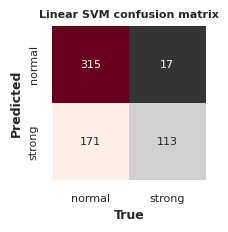

In [19]:
plot_cfm(y_test, y_pred_test, title="Linear SVM confusion matrix", cmap=CMAP_CFM)

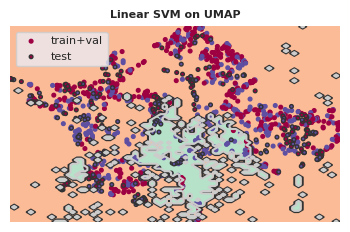

In [20]:
boundaries_on_embedding(reducer, lin_svc, embedding=embedding, 
                        title=f"Linear SVM on {embedding_name}", 
                        cmap=CMAP,
                       n_pts=N_PTS)

In [21]:
# decision_function = lin_svc.decision_function(X_train)
# support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
# support_vectors = X_train[support_vector_indices]

In [22]:
# # Plots the decision function for diferent values of C
# for i, C in enumerate([0.02, 300]):
#     plt.figure(figsize=default_style.SHORT_HALFSIZE_FIGURE)

#     cmap="viridis"
#     clf = LinearSVC(C=C, loss="hinge", penalty='l2', random_state=42).fit(X_test, y_test)

#     # Genearate a grid in embedding
#     xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), 30)
#     yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), 30)

#     XX, YY = np.meshgrid(xx, yy)
#     points_in_embedding = np.array(np.meshgrid(xx, yy)).T
#     old_shape = points_in_embedding.shape[:-1]
    
#     # Maps them back in the big space
#     points_in_embedding = points_in_embedding.reshape(-1,2)
#     points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

#     # Gets results
#     results = clf.decision_function(points_in_gigaspace)
#     mappable=plt.contourf(XX, YY, results.reshape(old_shape).T, cmap="viridis", alpha=0.6, levels=15)
#     plt.scatter(*embedding[test_mask].T, c=y_test, marker="o", edgecolor="k", s=5,cmap=cmap, label="test")
#     plt.scatter(*embedding[~test_mask].T, c=y[~test_mask], marker="+",  s=5, cmap=cmap, label="train+val")
    
#     # Plot support
#     results = clf.decision_function(X_train)
#     support_vector_indices = np.where((2 * y_train - 1) * results <= 1)[0]
#     plt.scatter(*(embedding[~test_mask][support_vector_indices]).T, s=10, color="r")
#     plt.axis("off")
# #     decision_function = clf.decision_function(X_res_t)
# # #     we can also calculate the decision function manually
# # #     decision_function = np.dot(X_pca, clf.coef_[0]) + clf.intercept_[0]
# #     support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
# #     support_vectors = X_res_t[support_vector_indices]
# #     support_vectors_pca = pca.transform(support_vectors)

# #     plt.subplot(1, 2, i + 1)
# #     plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, s=30, cmap=plt.cm.Paired)
# #     ax = plt.gca()
# #     xlim = ax.get_xlim()
# #     ylim = ax.get_ylim()
# #     xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
# #                          np.linspace(ylim[0], ylim[1], 50))
# #     clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X_pca, y_res_t)
# #     Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# #     Z = Z.reshape(xx.shape)
# #     plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
# #                 linestyles=['--', '-', '--'])
# #     plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100,
# #                 linewidth=1, facecolors='none', edgecolors='k')
# #     plt.title("C=" + str(C))
# #     #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
# # plt.tight_layout()
# # plt.show()
#     plt.savefig(f"images/linear_svm_UMAP_decision_function_C_{C}.pdf")
#     plt.colorbar(mappable)

The goal for SVM is find hyperplane that maximizes the margin, furthermore C is the inverse of regularization strength therefore smaller value of C correspond a stronger regularization namely greater margin

## Nonlinear SVM

In [23]:
from sklearn.svm import SVC

In [24]:
# objective function to be minimized
def objective_fun(trial):

    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.1,80)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    degree = trial.suggest_int('degree', 1, 15)
    

    svc = SVC(kernel=kernel, gamma=gamma, C=C)

    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 250, n_jobs = -1, catch=(ValueError,))

[I 2023-07-09 11:49:10,615] A new study created in memory with name: no-name-c35aec84-d79f-4b2f-8475-bbfa79aca7e5
[I 2023-07-09 11:49:11,349] Trial 2 finished with value: 0.699724517906336 and parameters: {'kernel': 'sigmoid', 'C': 10.034110386460064, 'gamma': 0.014529858727869605, 'degree': 7}. Best is trial 2 with value: 0.699724517906336.
[I 2023-07-09 11:49:11,614] Trial 3 finished with value: 0.5013774104683195 and parameters: {'kernel': 'sigmoid', 'C': 25.325972645433907, 'gamma': 0.5779935837841464, 'degree': 6}. Best is trial 2 with value: 0.699724517906336.
[I 2023-07-09 11:49:11,645] Trial 1 finished with value: 0.5013774104683195 and parameters: {'kernel': 'sigmoid', 'C': 53.68475266503524, 'gamma': 0.4617894023244105, 'degree': 15}. Best is trial 2 with value: 0.699724517906336.
[I 2023-07-09 11:49:12,096] Trial 0 finished with value: 0.7630853994490359 and parameters: {'kernel': 'rbf', 'C': 77.91288663800233, 'gamma': 0.8681392083950019, 'degree': 15}. Best is trial 0 with

[I 2023-07-09 11:49:29,542] Trial 36 finished with value: 0.7575757575757576 and parameters: {'kernel': 'rbf', 'C': 72.50383568956732, 'gamma': 0.8247937912525343, 'degree': 7}. Best is trial 33 with value: 0.7658402203856749.
[I 2023-07-09 11:49:29,769] Trial 37 finished with value: 0.7630853994490359 and parameters: {'kernel': 'rbf', 'C': 72.91576736096671, 'gamma': 0.5933963161669129, 'degree': 7}. Best is trial 33 with value: 0.7658402203856749.
[I 2023-07-09 11:49:30,322] Trial 38 finished with value: 0.7630853994490359 and parameters: {'kernel': 'rbf', 'C': 68.01840701078729, 'gamma': 0.586436425377883, 'degree': 6}. Best is trial 33 with value: 0.7658402203856749.
[I 2023-07-09 11:49:30,924] Trial 39 finished with value: 0.7713498622589532 and parameters: {'kernel': 'rbf', 'C': 52.7056548390809, 'gamma': 0.5091558195860005, 'degree': 7}. Best is trial 39 with value: 0.7713498622589532.
[I 2023-07-09 11:49:31,601] Trial 41 finished with value: 0.5013774104683195 and parameters: {

[I 2023-07-09 11:49:46,440] Trial 72 finished with value: 0.5013774104683195 and parameters: {'kernel': 'sigmoid', 'C': 49.189242656168794, 'gamma': 0.314675327429539, 'degree': 4}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:49:46,993] Trial 73 finished with value: 0.5013774104683195 and parameters: {'kernel': 'sigmoid', 'C': 54.39454670519187, 'gamma': 0.3017933714252991, 'degree': 6}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:49:47,107] Trial 74 finished with value: 0.7768595041322314 and parameters: {'kernel': 'rbf', 'C': 54.375004312838314, 'gamma': 0.3133251361297196, 'degree': 5}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:49:47,777] Trial 76 finished with value: 0.7630853994490359 and parameters: {'kernel': 'rbf', 'C': 54.399274435967314, 'gamma': 0.2718663433634502, 'degree': 5}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:49:47,966] Trial 75 finished with value: 0.7713498622589532 and p

[I 2023-07-09 11:50:02,121] Trial 108 finished with value: 0.7713498622589532 and parameters: {'kernel': 'rbf', 'C': 59.18694548222419, 'gamma': 0.349662233980878, 'degree': 4}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:02,279] Trial 110 finished with value: 0.7768595041322314 and parameters: {'kernel': 'rbf', 'C': 64.89726278837928, 'gamma': 0.37071693584118476, 'degree': 4}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:02,352] Trial 109 finished with value: 0.7713498622589532 and parameters: {'kernel': 'rbf', 'C': 64.29863663829725, 'gamma': 0.30360105604305515, 'degree': 4}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:02,847] Trial 111 finished with value: 0.768595041322314 and parameters: {'kernel': 'rbf', 'C': 53.37439707091939, 'gamma': 0.29633071525784327, 'degree': 3}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:03,701] Trial 112 finished with value: 0.768595041322314 and parame

[I 2023-07-09 11:50:20,543] Trial 144 finished with value: 0.7768595041322314 and parameters: {'kernel': 'rbf', 'C': 60.33307840361782, 'gamma': 0.31784071792811724, 'degree': 6}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:20,725] Trial 145 finished with value: 0.768595041322314 and parameters: {'kernel': 'rbf', 'C': 60.158852024844634, 'gamma': 0.29721866462140273, 'degree': 6}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:21,093] Trial 146 finished with value: 0.7768595041322314 and parameters: {'kernel': 'rbf', 'C': 60.407779481029806, 'gamma': 0.31756837069823973, 'degree': 6}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:21,767] Trial 147 finished with value: 0.7741046831955923 and parameters: {'kernel': 'rbf', 'C': 66.60828654731296, 'gamma': 0.3093189502601655, 'degree': 7}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:21,944] Trial 148 finished with value: 0.7713498622589532 and pa

[I 2023-07-09 11:50:36,626] Trial 180 finished with value: 0.768595041322314 and parameters: {'kernel': 'rbf', 'C': 61.09563245714587, 'gamma': 0.28968742256274965, 'degree': 3}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:38,100] Trial 184 finished with value: 0.7768595041322314 and parameters: {'kernel': 'rbf', 'C': 54.75078567506146, 'gamma': 0.32159330858615515, 'degree': 4}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:39,471] Trial 181 finished with value: 0.6831955922865014 and parameters: {'kernel': 'poly', 'C': 69.42407328012202, 'gamma': 0.2867973625802432, 'degree': 2}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:39,521] Trial 183 finished with value: 0.6831955922865014 and parameters: {'kernel': 'poly', 'C': 47.629893531949925, 'gamma': 0.25386232461954567, 'degree': 2}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:39,584] Trial 182 finished with value: 0.6831955922865014 and p

[I 2023-07-09 11:50:55,989] Trial 214 finished with value: 0.7741046831955923 and parameters: {'kernel': 'rbf', 'C': 55.065922137747506, 'gamma': 0.45148396767108817, 'degree': 5}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:57,796] Trial 217 finished with value: 0.7741046831955923 and parameters: {'kernel': 'rbf', 'C': 55.7534744384583, 'gamma': 0.43318465603993456, 'degree': 5}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:58,117] Trial 219 finished with value: 0.7713498622589532 and parameters: {'kernel': 'rbf', 'C': 50.41256175665972, 'gamma': 0.33925471799917817, 'degree': 4}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:58,569] Trial 220 finished with value: 0.7713498622589532 and parameters: {'kernel': 'rbf', 'C': 62.66216274843089, 'gamma': 0.342081819648527, 'degree': 4}. Best is trial 46 with value: 0.7768595041322314.
[I 2023-07-09 11:50:58,607] Trial 218 finished with value: 0.7713498622589532 and para

In [25]:
best_params = study.best_params

svc = SVC(**best_params)
svc.fit(np.concatenate((X_train, X_val)),np.concatenate((y_train, y_val)))

y_pred_test = svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'kernel': 'rbf', 'C': 61.12294621410581, 'gamma': 0.43641536830652994, 'degree': 5}
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       332
           1       0.68      0.74      0.71       284

    accuracy                           0.72       616
   macro avg       0.72      0.72      0.72       616
weighted avg       0.73      0.72      0.72       616

Accuracy 0.7224025974025974
F1-score [0.73322933 0.7106599 ]


In [26]:
print(svc.support_vectors_.shape)
print(X.shape)

(1417, 231)
(2429, 231)


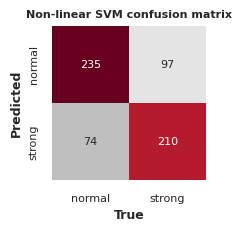

In [27]:
plot_cfm(y_test, y_pred_test, title="Non-linear SVM confusion matrix", cmap=CMAP_CFM)

In [28]:
# support_vectors_pca = pca.transform(svc.support_vectors_)

In [29]:
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, 
#             cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=10)
# plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=10,
#                 linewidth=1, facecolors='none', edgecolors='k')
# plt.show()

In [30]:
# decision_function = svc.decision_function(X_res_t)
# support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
# support_vectors = X_res_t[support_vector_indices]

In [31]:
# support_vectors_pca = pca.transform(support_vectors)

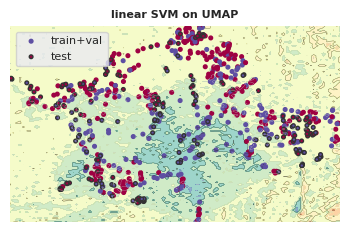

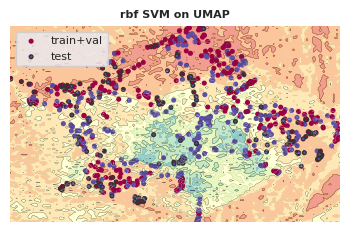

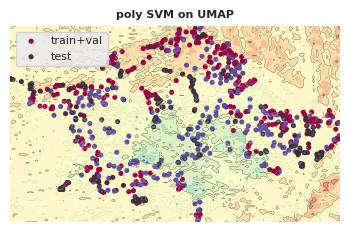

In [32]:
for kernel in ('linear', 'rbf', 'poly'):
    
    this_kernel_params = svc.get_params().copy()
    this_kernel_params["kernel"] = kernel
#     this_kernel_params["C"] = 0.5
    this_kernel_params["degree"] = 15
    
    clf = SVC(**this_kernel_params)
    clf.fit(X_train, y_train)
    
    boundaries_on_embedding(   reducer, clf, embedding=embedding,
                                title=f"{kernel} SVM on {embedding_name}",
                                plot_function="decision_function", levels=8, linewidths=0.2,
                                n_pts=100, subsamp_fraction=0.3,
                                cmap=CMAP
                           )
    

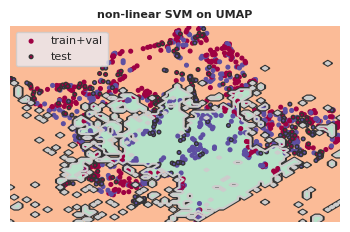

In [33]:
boundaries_on_embedding(reducer, svc, embedding=embedding, 
                        title=f"non-linear SVM on {embedding_name}", 
                        cmap=CMAP,
                        n_pts=N_PTS)
# plt.scatter(*(reducer.transform(svc.support_vectors_).T), color="r", s=10 , marker="+")

Show the different boundary for different kernel:
-Linear: just see previuos section
-Radial: Basis Function:The gamma parameters can be seen as the inverse of the radius of influence of   samples selected
-poly : the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these

# Neural Networks

In [34]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

In [35]:
from scikeras.wrappers import KerasClassifier

In [36]:
from sklearn.model_selection import RandomizedSearchCV

In [37]:
#  build the model for neural networks
def build_model(meta, hidden_layer_sizes, activation, optimizer):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [38]:
#Use Sklearn wrapper
clf = KerasClassifier(
    model = build_model,
    verbose = False
)

In [39]:
# objective function to be minimized
import random
import optuna
def objective_fun(trial):
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',[(100, 100, 100), (50, 50, 50), (10, 10, 10), 
                                  (100, 50, 10), (10, 10, 10), (10, 10)])
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': X.shape[1], 'n_classes_': len(np.unique(y))}                                      
                                          
    net = KerasClassifier(model=build_model(par, hidden_layer_sizes, activation, optimizer ))
    
    net.fit(X_train, y_train, epochs=50)
    y_pred = net.predict(X_val).astype(int)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-09 12:36:30,128] A new study created in memory with name: no-name-c51071ed-93c0-4816-93e3-e45254babf68
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50,

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
46/46 [==============================] - 5s 13ms/step - loss: 0.6885 - accuracy: 0.5490
Epoch 2/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6585 - accuracy: 0.6145
Epoch 3/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6383 - accuracy: 0.6662
Epoch 4/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6886 - accuracy: 0.5490
Epoch 5/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5657 - accuracy: 0.7083
Epoch 3/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6883 - accuracy: 0.5490
Epoch 8/50
Epoch 8/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5458 - accuracy: 0.7179
Epoch 6/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5429 - accuracy: 0.7269
Epoch 7/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5712 - accuracy: 0.7283
Epoch 12/50
46/46 [==============================] - 1s 12ms/step -

46/46 [==============================] - 1s 12ms/step - loss: 0.6886 - accuracy: 0.5490
Epoch 17/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5210 - accuracy: 0.7345
Epoch 13/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5163 - accuracy: 0.7359
Epoch 13/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5171 - accuracy: 0.7359
Epoch 14/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5181 - accuracy: 0.7366
Epoch 15/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5540 - accuracy: 0.7221
Epoch 20/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5539 - accuracy: 0.7179
Epoch 21/50
46/46 [==============================] - 0s 11ms/step - loss: 0.6884 - accuracy: 0.5490
Epoch 21/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5072 - accuracy: 0.7469
Epoch 17/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6885 - accuracy: 0.5490
Epoch 22/50


46/46 [==============================] - 1s 11ms/step - loss: 0.6881 - accuracy: 0.5490
Epoch 32/50
46/46 [==============================] - 0s 11ms/step - loss: 0.6879 - accuracy: 0.5490
Epoch 33/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6880 - accuracy: 0.5490
Epoch 34/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4722 - accuracy: 0.7648
Epoch 29/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5048 - accuracy: 0.7531
Epoch 31/50
46/46 [==============================] - 0s 11ms/step - loss: 0.4774 - accuracy: 0.7621
Epoch 31/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5367 - accuracy: 0.7324
Epoch 37/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6880 - accuracy: 0.5490
Epoch 37/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6882 - accuracy: 0.5490
Epoch 38/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4779 - accuracy: 0.7586
Epoch 34/50


46/46 [==============================] - 1s 12ms/step - loss: 0.6877 - accuracy: 0.5490
Epoch 46/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4348 - accuracy: 0.7917
Epoch 41/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6880 - accuracy: 0.5490
Epoch 47/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5287 - accuracy: 0.7331
Epoch 48/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4467 - accuracy: 0.7855
Epoch 42/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4644 - accuracy: 0.7655
Epoch 43/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6879 - accuracy: 0.5490
Epoch 48/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4271 - accuracy: 0.7876
Epoch 43/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6877 - accuracy: 0.5490
Epoch 49/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4291 - accuracy: 0.7993
Epoch 44/50


[I 2023-07-09 12:37:02,884] Trial 3 finished with value: 0.6776859504132231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.6776859504132231.


46/46 [==============================] - 1s 11ms/step - loss: 0.4420 - accuracy: 0.7807
Epoch 47/50
 1/12 [=>............................] - ETA: 3s - loss: 0.4276 - accuracy: 0.7852

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.4081 - accuracy: 0.8007
Epoch 47/50
37/46 [=======================>......] - ETA: 0s - loss: 0.4675 - accuracy: 0.7627

[I 2023-07-09 12:37:03,384] Trial 2 finished with value: 0.5013774104683195 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.6776859504132231.


46/46 [==============================] - 1s 11ms/step - loss: 0.4657 - accuracy: 0.7669
Epoch 48/50
25/46 [===============>..............] - ETA: 0s - loss: 0.4007 - accuracy: 0.8125

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.4684 - accuracy: 0.7662
Epoch 49/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4089 - accuracy: 0.8069
Epoch 49/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4433 - accuracy: 0.7848
Epoch 50/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4162 - accuracy: 0.7979
Epoch 50/50
12/12 [==============================] - 0s 7ms/step


[I 2023-07-09 12:37:05,833] Trial 1 finished with value: 0.7327823691460055 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 1 with value: 0.7327823691460055.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical di

Epoch 1/50
46/46 [==============================] - 4s 10ms/step - loss: 0.6657 - accuracy: 0.6207
Epoch 2/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6496 - accuracy: 0.6552
Epoch 3/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6340 - accuracy: 0.6910
Epoch 4/50
46/46 [==============================] - 6s 8ms/step - loss: 0.6421 - accuracy: 0.6283
Epoch 2/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6574 - accuracy: 0.6462
Epoch 3/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5970 - accuracy: 0.6986
Epoch 7/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5770 - accuracy: 0.7000
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5875 - accuracy: 0.7117
Epoch 8/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5568 - accuracy: 0.7166
Epoch 4/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6236 - accuracy: 0.6828
Epoch 5/50
46/46 [=

46/46 [==============================] - 0s 8ms/step - loss: 0.5457 - accuracy: 0.7303
Epoch 27/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5493 - accuracy: 0.7269
Epoch 24/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4988 - accuracy: 0.7441
Epoch 23/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5361 - accuracy: 0.7338
Epoch 28/50
Epoch 25/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4997 - accuracy: 0.7421
Epoch 24/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5028 - accuracy: 0.7455
Epoch 25/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5466 - accuracy: 0.7214
Epoch 27/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5378 - accuracy: 0.7269
Epoch 30/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4987 - accuracy: 0.7434
Epoch 26/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5429 - accuracy: 0.7283
Epoch 29/

[I 2023-07-09 12:37:19,946] Trial 0 finished with value: 0.7603305785123967 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


29/46 [=================>............] - ETA: 0s - loss: 0.5306 - accuracy: 0.7274

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.5359 - accuracy: 0.7283
Epoch 33/50
38/46 [=======================>......] - ETA: 0s - loss: 0.5040 - accuracy: 0.7475Epoch 1/50
Epoch 31/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4992 - accuracy: 0.7531
Epoch 29/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5410 - accuracy: 0.7269
Epoch 32/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5396 - accuracy: 0.7276
Epoch 33/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5408 - accuracy: 0.7269
Epoch 37/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5295 - accuracy: 0.7317
Epoch 38/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4736 - accuracy: 0.7579
Epoch 34/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5380 - accuracy: 0.7269
Epoch 37/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4878 - accuracy: 0.7579
Epoch 35

46/46 [==============================] - 1s 12ms/step - loss: 0.5598 - accuracy: 0.7228
Epoch 6/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5278 - accuracy: 0.7379
Epoch 49/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5615 - accuracy: 0.7103
Epoch 7/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5293 - accuracy: 0.7366
Epoch 50/50
42/46 [==========================>...] - ETA: 0s - loss: 0.5482 - accuracy: 0.7284

[I 2023-07-09 12:37:32,528] Trial 5 finished with value: 0.6776859504132231 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 1s 11ms/step - loss: 0.4410 - accuracy: 0.7800
Epoch 48/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5277 - accuracy: 0.7269


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.5464 - accuracy: 0.7352
Epoch 9/50
41/46 [=========================>....] - ETA: 0s - loss: 0.5359 - accuracy: 0.7393

[I 2023-07-09 12:37:33,670] Trial 6 finished with value: 0.6887052341597796 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 1s 11ms/step - loss: 0.4536 - accuracy: 0.7752
Epoch 50/50
 1/46 [..............................] - ETA: 0s - loss: 0.3814 - accuracy: 0.7812

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 11ms/step - loss: 0.5399 - accuracy: 0.7331
Epoch 12/50
40/46 [=========================>....] - ETA: 0s - loss: 0.5334 - accuracy: 0.7375

[I 2023-07-09 12:37:35,268] Trial 4 finished with value: 0.7272727272727273 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 10ms/step - loss: 0.5294 - accuracy: 0.7407
Epoch 13/50
10/46 [=====>........................] - ETA: 0s - loss: 0.5371 - accuracy: 0.7281

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 0.5287 - accuracy: 0.7414
Epoch 14/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5274 - accuracy: 0.7269
Epoch 15/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5253 - accuracy: 0.7324
Epoch 16/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5251 - accuracy: 0.7331
Epoch 17/50
46/46 [==============================] - 4s 12ms/step - loss: 0.6940 - accuracy: 0.5193
Epoch 2/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5195 - accuracy: 0.7359
Epoch 18/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5260 - accuracy: 0.7324
Epoch 19/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5280 - accuracy: 0.7331
Epoch 20/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6689 - accuracy: 0.5710
Epoch 5/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6665 - accuracy: 0.5869
Epoch 21/50
Ep

46/46 [==============================] - 1s 12ms/step - loss: 0.5735 - accuracy: 0.7152
Epoch 16/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5051 - accuracy: 0.7469
Epoch 20/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5423 - accuracy: 0.7324
Epoch 11/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5434 - accuracy: 0.7269
Epoch 12/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5049 - accuracy: 0.7407
Epoch 37/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5667 - accuracy: 0.7117
Epoch 19/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5719 - accuracy: 0.7138
Epoch 23/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5648 - accuracy: 0.7200
Epoch 20/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5474 - accuracy: 0.7297
Epoch 14/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4966 - accuracy: 0.7490
Epoch 39/50


46/46 [==============================] - 0s 9ms/step - loss: 0.5442 - accuracy: 0.7255
Epoch 31/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5478 - accuracy: 0.7297
Epoch 35/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5456 - accuracy: 0.7241
Epoch 32/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5494 - accuracy: 0.7241
Epoch 36/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5450 - accuracy: 0.7241
Epoch 33/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5478 - accuracy: 0.7290
Epoch 37/50
46/46 [==============================] - ETA: 0s - loss: 0.5269 - accuracy: 0.7400

[I 2023-07-09 12:37:55,781] Trial 7 finished with value: 0.7052341597796143 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 9ms/step - loss: 0.5269 - accuracy: 0.7400
Epoch 28/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5392 - accuracy: 0.7359
Epoch 34/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5474 - accuracy: 0.7234


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 11ms/step - loss: 0.5282 - accuracy: 0.7400
Epoch 29/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5410 - accuracy: 0.7317
Epoch 35/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5460 - accuracy: 0.7262
Epoch 39/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5387 - accuracy: 0.7248
Epoch 30/50
Epoch 36/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5201 - accuracy: 0.7345
Epoch 31/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5410 - accuracy: 0.7297
Epoch 37/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5415 - accuracy: 0.7379
Epoch 41/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5359 - accuracy: 0.7324
Epoch 40/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5379 - accuracy: 0.7338
Epoch 44/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5308 - accuracy: 0.7324


[I 2023-07-09 12:38:03,947] Trial 8 finished with value: 0.699724517906336 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 10ms/step - loss: 0.5270 - accuracy: 0.7414
Epoch 49/50
18/46 [==========>...................] - ETA: 0s - loss: 0.6873 - accuracy: 0.5608

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.5288 - accuracy: 0.7379
Epoch 50/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6891 - accuracy: 0.5490
Epoch 11/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5043 - accuracy: 0.7510
Epoch 47/50
22/46 [=============>................] - ETA: 0s - loss: 0.5060 - accuracy: 0.7585

[I 2023-07-09 12:38:05,984] Trial 9 finished with value: 0.7024793388429752 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


44/46 [===========================>..] - ETA: 0s - loss: 0.5065 - accuracy: 0.7550

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.5042 - accuracy: 0.7545
Epoch 48/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6892 - accuracy: 0.5490
Epoch 13/50
Epoch 1/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6891 - accuracy: 0.5490
Epoch 14/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4982 - accuracy: 0.7531
Epoch 50/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6891 - accuracy: 0.5490
Epoch 15/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6891 - accuracy: 0.5490
Epoch 16/50
20/46 [============>.................] - ETA: 0s - loss: 0.6855 - accuracy: 0.5672

[I 2023-07-09 12:38:08,514] Trial 10 finished with value: 0.7107438016528925 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


38/46 [=======================>......] - ETA: 0s - loss: 0.6872 - accuracy: 0.5584

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.6900 - accuracy: 0.5490
Epoch 3/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6891 - accuracy: 0.5490
Epoch 19/50
46/46 [==============================] - 0s 11ms/step - loss: 0.6893 - accuracy: 0.5490
Epoch 4/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6890 - accuracy: 0.5490
Epoch 21/50
46/46 [==============================] - 0s 11ms/step - loss: 0.6888 - accuracy: 0.5490
Epoch 6/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6888 - accuracy: 0.5490
Epoch 7/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6887 - accuracy: 0.5490
Epoch 8/50
46/46 [==============================] - 0s 11ms/step - loss: 0.6887 - accuracy: 0.5490
Epoch 9/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6887 - accuracy: 0.5490
Epoch 25/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6887 - accuracy: 0.5490
Epoch 10/50
46/46 

46/46 [==============================] - 0s 10ms/step - loss: 0.5852 - accuracy: 0.7200
Epoch 13/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5772 - accuracy: 0.7262
Epoch 14/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6738 - accuracy: 0.5490
Epoch 9/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6886 - accuracy: 0.5490
Epoch 24/50
46/46 [==============================] - 0s 11ms/step - loss: 0.6889 - accuracy: 0.5490
Epoch 39/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6662 - accuracy: 0.5690
Epoch 10/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6887 - accuracy: 0.5490
Epoch 25/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5680 - accuracy: 0.7262
Epoch 16/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6887 - accuracy: 0.5490
Epoch 26/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6455 - accuracy: 0.6786
Epoch 27/50
Epo

46/46 [==============================] - 1s 12ms/step - loss: 0.5657 - accuracy: 0.7214
Epoch 21/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6886 - accuracy: 0.5490
Epoch 37/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5459 - accuracy: 0.7276
Epoch 27/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5614 - accuracy: 0.7297
Epoch 22/50
 1/46 [..............................] - ETA: 0s - loss: 0.5139 - accuracy: 0.7812

[I 2023-07-09 12:38:27,412] Trial 11 finished with value: 0.5013774104683195 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


40/46 [=========================>....] - ETA: 0s - loss: 0.6878 - accuracy: 0.5531

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.6886 - accuracy: 0.5490
Epoch 39/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5424 - accuracy: 0.7352
Epoch 29/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5565 - accuracy: 0.7303
Epoch 24/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5398 - accuracy: 0.7372
Epoch 30/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5542 - accuracy: 0.7269
Epoch 25/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6886 - accuracy: 0.5490
Epoch 41/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6886 - accuracy: 0.5490
Epoch 42/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5364 - accuracy: 0.7421
Epoch 32/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5517 - accuracy: 0.7331
Epoch 27/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6885 - accuracy: 0.5490
Epoch 43/50


[I 2023-07-09 12:38:34,975] Trial 12 finished with value: 0.5013774104683195 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 7s 10ms/step - loss: 0.6773 - accuracy: 0.6090


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 11ms/step - loss: 0.5377 - accuracy: 0.7338
Epoch 38/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5260 - accuracy: 0.7483
Epoch 1/50
Epoch 44/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5354 - accuracy: 0.7366
Epoch 39/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5261 - accuracy: 0.7428
Epoch 45/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6015 - accuracy: 0.6966
Epoch 4/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5260 - accuracy: 0.7476
Epoch 47/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5672 - accuracy: 0.7131
Epoch 6/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5239 - accuracy: 0.7462
Epoch 48/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5241 - accuracy: 0.7462
Epoch 49/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5547 - accuracy: 0.7159
Epo

[I 2023-07-09 12:38:40,184] Trial 13 finished with value: 0.6804407713498623 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


29/46 [=================>............] - ETA: 0s - loss: 0.5339 - accuracy: 0.7371

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 13ms/step - loss: 0.5297 - accuracy: 0.7434
Epoch 47/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5437 - accuracy: 0.7324
Epoch 12/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5386 - accuracy: 0.7234
Epoch 13/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5397 - accuracy: 0.7317
Epoch 14/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5264 - accuracy: 0.7476
Epoch 50/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5327 - accuracy: 0.7372
Epoch 15/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5260 - accuracy: 0.7434
Epoch 16/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5327 - accuracy: 0.7317
Epoch 17/50
16/46 [=========>....................] - ETA: 0s - loss: 0.6320 - accuracy: 0.6699

[I 2023-07-09 12:38:43,688] Trial 14 finished with value: 0.6942148760330579 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 10ms/step - loss: 0.5270 - accuracy: 0.7393


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.6183 - accuracy: 0.6938
Epoch 4/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5373 - accuracy: 0.7352
Epoch 19/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5946 - accuracy: 0.6959
Epoch 5/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5803 - accuracy: 0.7062
Epoch 6/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5234 - accuracy: 0.7462
Epoch 21/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5693 - accuracy: 0.7186
Epoch 7/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5605 - accuracy: 0.7186
Epoch 22/50
Epoch 8/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6192 - accuracy: 0.6959
Epoch 3/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5925 - accuracy: 0.6986
Epoch 4/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5504 - accuracy: 0.7310
Epoch 11

46/46 [==============================] - 1s 11ms/step - loss: 0.5369 - accuracy: 0.7366
Epoch 23/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5426 - accuracy: 0.7324
Epoch 8/50
27/46 [================>.............] - ETA: 0s - loss: 0.5352 - accuracy: 0.7269Epoch 38/50
Epoch 24/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5329 - accuracy: 0.7393
Epoch 17/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5221 - accuracy: 0.7386
Epoch 25/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5120 - accuracy: 0.7476
Epoch 39/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5295 - accuracy: 0.7428
Epoch 18/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5121 - accuracy: 0.7497
Epoch 40/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5215 - accuracy: 0.7324
Epoch 11/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5187 - accuracy: 0.7421
Epoch 2

24/46 [==============>...............] - ETA: 0s - loss: 0.4925 - accuracy: 0.7565

[I 2023-07-09 12:39:02,191] Trial 15 finished with value: 0.6831955922865014 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


44/46 [===========================>..] - ETA: 0s - loss: 0.4967 - accuracy: 0.7536

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 11ms/step - loss: 0.5131 - accuracy: 0.7469
Epoch 32/50
46/46 [==============================] - 0s 11ms/step - loss: 0.4965 - accuracy: 0.7538
Epoch 23/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5105 - accuracy: 0.7469
Epoch 40/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5122 - accuracy: 0.7421
Epoch 24/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5142 - accuracy: 0.7490
Epoch 34/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5114 - accuracy: 0.7448
Epoch 26/50
Epoch 35/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5087 - accuracy: 0.7503
Epoch 43/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4929 - accuracy: 0.7510
Epoch 36/50
Epoch 27/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5013 - accuracy: 0.7524
Epoch 44/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5156 - accur

[I 2023-07-09 12:39:11,832] Trial 17 finished with value: 0.7107438016528925 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 8ms/step - loss: 0.5676 - accuracy: 0.7228
Epoch 8/50
38/46 [=======================>......] - ETA: 0s - loss: 0.4740 - accuracy: 0.7615

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.4661 - accuracy: 0.7662
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5669 - accuracy: 0.7097
Epoch 9/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5582 - accuracy: 0.7310
Epoch 10/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4567 - accuracy: 0.7710
Epoch 45/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5559 - accuracy: 0.7234
Epoch 11/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5539 - accuracy: 0.7331
Epoch 12/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4527 - accuracy: 0.7738
Epoch 47/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5486 - accuracy: 0.7372
Epoch 13/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4485 - accuracy: 0.7779
Epoch 48/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5541 - accuracy: 0.7214
Epoch 14/50
46/46 [===

46/46 [==============================] - 0s 5ms/step - loss: 0.5092 - accuracy: 0.7572
Epoch 46/50
46/46 [==============================] - 0s 5ms/step - loss: 0.5071 - accuracy: 0.7441
Epoch 27/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5130 - accuracy: 0.7497
Epoch 47/50
46/46 [==============================] - 0s 5ms/step - loss: 0.5101 - accuracy: 0.7476
Epoch 28/50
46/46 [==============================] - 0s 5ms/step - loss: 0.5101 - accuracy: 0.7545
Epoch 48/50
46/46 [==============================] - 0s 5ms/step - loss: 0.5176 - accuracy: 0.7393
Epoch 29/50
46/46 [==============================] - 0s 5ms/step - loss: 0.5104 - accuracy: 0.7476
Epoch 49/50
46/46 [==============================] - 0s 5ms/step - loss: 0.5043 - accuracy: 0.7462
Epoch 30/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5081 - accuracy: 0.7552
Epoch 50/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5031 - accuracy: 0.7476
Epoch 31/50
37/46 [===

[I 2023-07-09 12:39:23,958] Trial 16 finished with value: 0.7052341597796143 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 9ms/step - loss: 0.5055 - accuracy: 0.7476
Epoch 32/50
 1/46 [..............................] - ETA: 0s - loss: 0.4863 - accuracy: 0.7812

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

14/46 [========>.....................] - ETA: 0s - loss: 0.5072 - accuracy: 0.7589

[I 2023-07-09 12:39:24,624] Trial 19 finished with value: 0.696969696969697 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


28/46 [=================>............] - ETA: 0s - loss: 0.4990 - accuracy: 0.7533

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.4981 - accuracy: 0.7483
Epoch 34/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5060 - accuracy: 0.7545
Epoch 35/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5007 - accuracy: 0.7538
Epoch 36/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4987 - accuracy: 0.7566
Epoch 37/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4954 - accuracy: 0.7510
Epoch 38/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4938 - accuracy: 0.7524
Epoch 39/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4961 - accuracy: 0.7572
Epoch 40/50
46/46 [==============================] - 0s 11ms/step - loss: 0.4964 - accuracy: 0.7600
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4973 - accuracy: 0.7545
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5021 - accuracy: 0.7483
Epoch 43/50
46/46 [=

[I 2023-07-09 12:39:32,086] Trial 18 finished with value: 0.7079889807162535 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


40/46 [=========================>....] - ETA: 0s - loss: 0.4777 - accuracy: 0.7656

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 0.5276 - accuracy: 0.7317
Epoch 8/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5361 - accuracy: 0.7310
Epoch 9/50
44/46 [===========================>..] - ETA: 0s - loss: 0.5468 - accuracy: 0.7180

[I 2023-07-09 12:39:33,270] Trial 20 finished with value: 0.699724517906336 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 1s 11ms/step - loss: 0.5484 - accuracy: 0.7193
Epoch 8/50
22/46 [=============>................] - ETA: 0s - loss: 0.5327 - accuracy: 0.7301

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.5257 - accuracy: 0.7303
Epoch 10/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5322 - accuracy: 0.7317
Epoch 10/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5197 - accuracy: 0.7317
Epoch 12/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5263 - accuracy: 0.7338
Epoch 12/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5223 - accuracy: 0.7283
Epoch 13/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5344 - accuracy: 0.7248
Epoch 14/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5217 - accuracy: 0.7366
Epoch 16/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5243 - accuracy: 0.7241
Epoch 18/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5413 - accuracy: 0.7310
Epoch 18/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5139 - accuracy: 0.7310
Epoch 19/50


46/46 [==============================] - 1s 12ms/step - loss: 0.4969 - accuracy: 0.7510
Epoch 27/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5202 - accuracy: 0.7359
Epoch 28/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5316 - accuracy: 0.7372
Epoch 12/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5342 - accuracy: 0.7248
Epoch 10/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5333 - accuracy: 0.7310
Epoch 31/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4962 - accuracy: 0.7434
Epoch 31/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5169 - accuracy: 0.7379
Epoch 12/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4856 - accuracy: 0.7586
Epoch 33/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4935 - accuracy: 0.7524
Epoch 32/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5123 - accuracy: 0.7434
Epoch 14/50


46/46 [==============================] - 1s 11ms/step - loss: 0.4696 - accuracy: 0.7697
Epoch 41/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4754 - accuracy: 0.7600
Epoch 40/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5099 - accuracy: 0.7476
Epoch 24/50
46/46 [==============================] - 1s 13ms/step - loss: 0.4649 - accuracy: 0.7655
Epoch 42/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4520 - accuracy: 0.7800
Epoch 43/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4908 - accuracy: 0.7655
Epoch 23/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4566 - accuracy: 0.7745
Epoch 44/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4942 - accuracy: 0.7545
Epoch 24/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4685 - accuracy: 0.7717
Epoch 44/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4519 - accuracy: 0.7814
Epoch 45/50


[I 2023-07-09 12:39:57,701] Trial 21 finished with value: 0.7300275482093664 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 11ms/step - loss: 0.4965 - accuracy: 0.7538
Epoch 36/50
28/46 [=================>............] - ETA: 0s - loss: 0.4763 - accuracy: 0.7679

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.4670 - accuracy: 0.7745
Epoch 33/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4900 - accuracy: 0.7510
Epoch 37/50
26/46 [===============>..............] - ETA: 0s - loss: 0.4672 - accuracy: 0.7764

[I 2023-07-09 12:39:58,488] Trial 22 finished with value: 0.7052341597796143 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


19/46 [===========>..................] - ETA: 0s - loss: 0.5008 - accuracy: 0.7451

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 13ms/step - loss: 0.4695 - accuracy: 0.7745
Epoch 34/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4897 - accuracy: 0.7586
Epoch 38/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4954 - accuracy: 0.7462
Epoch 39/50
46/46 [==============================] - 1s 13ms/step - loss: 0.4827 - accuracy: 0.7566
Epoch 41/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4533 - accuracy: 0.7731
Epoch 38/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4797 - accuracy: 0.7524
Epoch 42/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4594 - accuracy: 0.7828
Epoch 39/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4904 - accuracy: 0.7483
Epoch 43/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4811 - accuracy: 0.7545
Epoch 44/50
46/46 [==============================] - 1s 13ms/step - loss: 0.4540 - accuracy: 0.7821
Epoch 41/50


[I 2023-07-09 12:40:07,292] Trial 23 finished with value: 0.71900826446281 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


 1/46 [..............................] - ETA: 0s - loss: 0.5950 - accuracy: 0.7500

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 0.4271 - accuracy: 0.7938
Epoch 1/50
Epoch 50/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5787 - accuracy: 0.7090
Epoch 6/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5433 - accuracy: 0.7221
Epoch 7/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5360 - accuracy: 0.7310
Epoch 8/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5321 - accuracy: 0.7303
Epoch 9/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5540 - accuracy: 0.7172
Epoch 9/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5501 - accuracy: 0.7228
Epoch 10/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5171 - accuracy: 0.7448
Epoch 11/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5450 - accuracy: 0.7255
Epoch 11/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5323 - accuracy: 0.7269
Epoch 12/5

46/46 [==============================] - 0s 6ms/step - loss: 0.5251 - accuracy: 0.7462
Epoch 15/50
46/46 [==============================] - 0s 5ms/step - loss: 0.4859 - accuracy: 0.7503
Epoch 30/50
46/46 [==============================] - 0s 5ms/step - loss: 0.5382 - accuracy: 0.7352
Epoch 16/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5391 - accuracy: 0.7241
Epoch 17/50
46/46 [==============================] - 0s 6ms/step - loss: 0.4850 - accuracy: 0.7552
Epoch 32/50
46/46 [==============================] - 0s 5ms/step - loss: 0.5223 - accuracy: 0.7414
Epoch 33/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5319 - accuracy: 0.7366
Epoch 18/50
46/46 [==============================] - 0s 6ms/step - loss: 0.4683 - accuracy: 0.7621
Epoch 33/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5297 - accuracy: 0.7421
Epoch 19/50
46/46 [==============================] - 0s 6ms/step - loss: 0.4728 - accuracy: 0.7724
Epoch 34/50
46/46 [===

[I 2023-07-09 12:40:22,368] Trial 24 finished with value: 0.7272727272727273 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


39/46 [========================>.....] - ETA: 0s - loss: 0.5010 - accuracy: 0.7612

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.4423 - accuracy: 0.7766
Epoch 50/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5156 - accuracy: 0.7510
Epoch 37/50
28/46 [=================>............] - ETA: 0s - loss: 0.4929 - accuracy: 0.7623

[I 2023-07-09 12:40:23,333] Trial 26 finished with value: 0.696969696969697 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 9ms/step - loss: 0.5062 - accuracy: 0.7434
Epoch 38/50
 1/46 [..............................] - ETA: 0s - loss: 0.5293 - accuracy: 0.7188

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.5070 - accuracy: 0.7414
Epoch 39/50
17/46 [==========>...................] - ETA: 0s - loss: 0.5203 - accuracy: 0.7463

[I 2023-07-09 12:40:23,997] Trial 25 finished with value: 0.7134986225895317 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


33/46 [====================>.........] - ETA: 0s - loss: 0.5086 - accuracy: 0.7481

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.5085 - accuracy: 0.7490
Epoch 40/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4980 - accuracy: 0.7462
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5055 - accuracy: 0.7524
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4974 - accuracy: 0.7579
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4974 - accuracy: 0.7524
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4947 - accuracy: 0.7566
Epoch 45/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4994 - accuracy: 0.7497
Epoch 46/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4926 - accuracy: 0.7621
Epoch 47/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4998 - accuracy: 0.7462
Epoch 48/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5004 - accuracy: 0.7600
Epoch 49/50
46/46 [=

[I 2023-07-09 12:40:29,604] Trial 27 finished with value: 0.721763085399449 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


30/46 [==================>...........] - ETA: 0s - loss: 0.6178 - accuracy: 0.6875

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.6195 - accuracy: 0.6772
Epoch 4/50
46/46 [==============================] - 6s 8ms/step - loss: 0.6854 - accuracy: 0.5731
Epoch 2/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6501 - accuracy: 0.6738
Epoch 3/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6102 - accuracy: 0.6848
Epoch 4/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5581 - accuracy: 0.7228
Epoch 7/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5799 - accuracy: 0.7110
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5714 - accuracy: 0.7186
Epoch 5/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5717 - accuracy: 0.7131
Epoch 6/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5647 - accuracy: 0.7172
Epoch 6/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5451 - accuracy: 0.7221
Epoch 10/50
46/46 [============

46/46 [==============================] - 0s 8ms/step - loss: 0.5355 - accuracy: 0.7393
Epoch 21/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5270 - accuracy: 0.7352
Epoch 22/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5295 - accuracy: 0.7269
Epoch 22/50
Epoch 8/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5268 - accuracy: 0.7331
Epoch 23/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5462 - accuracy: 0.7200
Epoch 9/50
Epoch 23/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5250 - accuracy: 0.7359
Epoch 24/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5140 - accuracy: 0.7441
Epoch 26/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5448 - accuracy: 0.7276
Epoch 10/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5251 - accuracy: 0.7379
Epoch 25/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5422 - accuracy: 0.7262


46/46 [==============================] - 0s 8ms/step - loss: 0.5023 - accuracy: 0.7566
Epoch 37/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5139 - accuracy: 0.7421
Epoch 38/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4998 - accuracy: 0.7572
Epoch 40/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5129 - accuracy: 0.7338
Epoch 24/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5001 - accuracy: 0.7552
Epoch 38/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5123 - accuracy: 0.7345
Epoch 25/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5011 - accuracy: 0.7545
Epoch 39/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5111 - accuracy: 0.7462
Epoch 26/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5062 - accuracy: 0.7524
Epoch 40/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4952 - accuracy: 0.7607
Epoch 41/50
46/46 [=

[I 2023-07-09 12:40:50,199] Trial 28 finished with value: 0.7079889807162535 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


23/46 [==============>...............] - ETA: 0s - loss: 0.5121 - accuracy: 0.7364

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.5153 - accuracy: 0.7414
Epoch 37/50
45/46 [============================>.] - ETA: 0s - loss: 0.5119 - accuracy: 0.7431

[I 2023-07-09 12:40:51,004] Trial 29 finished with value: 0.6831955922865014 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 8ms/step - loss: 0.5119 - accuracy: 0.7434
Epoch 38/50
19/46 [===========>..................] - ETA: 0s - loss: 0.5150 - accuracy: 0.7303

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

35/46 [=====================>........] - ETA: 0s - loss: 0.5129 - accuracy: 0.7393

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.5029 - accuracy: 0.7503
Epoch 39/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4959 - accuracy: 0.7510
Epoch 40/50
46/46 [==============================] - 0s 11ms/step - loss: 0.4911 - accuracy: 0.7524
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4934 - accuracy: 0.7497
Epoch 42/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4986 - accuracy: 0.7483
Epoch 43/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4909 - accuracy: 0.7531
Epoch 44/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4905 - accuracy: 0.7552
Epoch 45/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4865 - accuracy: 0.7538
Epoch 46/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4854 - accuracy: 0.7572
Epoch 47/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4895 - accuracy: 0.7497
Epoch 48/50
46/46 [

[I 2023-07-09 12:40:57,143] Trial 31 finished with value: 0.699724517906336 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical dis

46/46 [==============================] - 6s 8ms/step - loss: 0.7249 - accuracy: 0.5490
Epoch 2/50
46/46 [==============================] - 6s 8ms/step - loss: 0.6139 - accuracy: 0.6669
Epoch 2/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6963 - accuracy: 0.5490
Epoch 3/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5628 - accuracy: 0.7179
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5490
Epoch 4/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6875 - accuracy: 0.5490
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5604 - accuracy: 0.7041
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6856 - accuracy: 0.5490
Epoch 6/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5414 - accuracy: 0.7214
Epoch 6/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5361 - accuracy: 0.7366
Epoch 7/50
46/46 [=============

46/46 [==============================] - 0s 9ms/step - loss: 0.5407 - accuracy: 0.7283
Epoch 15/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5386 - accuracy: 0.7310
Epoch 16/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4920 - accuracy: 0.7538
Epoch 25/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4853 - accuracy: 0.7621
Epoch 26/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5582 - accuracy: 0.7324
Epoch 27/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5390 - accuracy: 0.7221
Epoch 14/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5350 - accuracy: 0.7262
Epoch 18/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5358 - accuracy: 0.7290
Epoch 16/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5303 - accuracy: 0.7366
Epoch 20/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4909 - accuracy: 0.7600
Epoch 29/50
46/46 [===

46/46 [==============================] - 0s 8ms/step - loss: 0.4645 - accuracy: 0.7697
Epoch 37/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5168 - accuracy: 0.7490
Epoch 29/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5420 - accuracy: 0.7407
Epoch 39/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5165 - accuracy: 0.7545
Epoch 30/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5288 - accuracy: 0.7310
Epoch 27/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5223 - accuracy: 0.7324
Epoch 28/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4475 - accuracy: 0.7772
Epoch 40/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5191 - accuracy: 0.7372
Epoch 32/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5164 - accuracy: 0.7510
Epoch 41/50
Epoch 33/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5382 - accuracy: 0.7393
Epoch 43/5

[I 2023-07-09 12:41:16,588] Trial 33 finished with value: 0.6859504132231405 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


31/46 [===================>..........] - ETA: 0s - loss: 0.5028 - accuracy: 0.7651

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.5053 - accuracy: 0.7572
Epoch 40/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5192 - accuracy: 0.7400
Epoch 44/50
12/12 [==============================] - 0s 7ms/steposs: 0.5019 - accuracy: 0.75
Epoch 45/50
35/46 [=====================>........] - ETA: 0s - loss: 0.5194 - accuracy: 0.7491

[I 2023-07-09 12:41:17,562] Trial 34 finished with value: 0.7300275482093664 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 7ms/step - loss: 0.5150 - accuracy: 0.7483
Epoch 46/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5061 - accuracy: 0.7421
Epoch 42/50
 8/46 [====>.........................] - ETA: 0s - loss: 0.4581 - accuracy: 0.7930

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.5058 - accuracy: 0.7545
Epoch 47/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4996 - accuracy: 0.7483
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5154 - accuracy: 0.7414
Epoch 48/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5070 - accuracy: 0.7524
Epoch 49/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5036 - accuracy: 0.7572
Epoch 45/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5020 - accuracy: 0.7683
Epoch 50/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4927 - accuracy: 0.7607
Epoch 46/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4964 - accuracy: 0.7545
Epoch 47/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5149 - accuracy: 0.7441
Epoch 48/50
 8/46 [====>.........................] - ETA: 0s - loss: 0.5044 - accuracy: 0.7461

[I 2023-07-09 12:41:20,310] Trial 32 finished with value: 0.7079889807162535 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


28/46 [=================>............] - ETA: 0s - loss: 0.4827 - accuracy: 0.7656

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.4962 - accuracy: 0.7531
Epoch 49/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4925 - accuracy: 0.7545
Epoch 50/50
12/12 [==============================] - 0s 6ms/step


[I 2023-07-09 12:41:22,098] Trial 35 finished with value: 0.7024793388429752 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical di

Epoch 1/50
46/46 [==============================] - 6s 6ms/step - loss: 0.6491 - accuracy: 0.6338
Epoch 2/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6013 - accuracy: 0.6869
Epoch 3/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5793 - accuracy: 0.7000
Epoch 4/50
46/46 [==============================] - 6s 9ms/step - loss: 0.6583 - accuracy: 0.6407
Epoch 2/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5643 - accuracy: 0.7248
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6204 - accuracy: 0.6669
Epoch 3/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5641 - accuracy: 0.7221
Epoch 6/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5550 - accuracy: 0.7152
Epoch 7/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5708 - accuracy: 0.7083
Epoch 5/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5536 - accuracy: 0.7179
Epoch 8/50
46/46 [=

46/46 [==============================] - 0s 8ms/step - loss: 0.5449 - accuracy: 0.7221
Epoch 11/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5111 - accuracy: 0.7359
Epoch 22/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5080 - accuracy: 0.7490
Epoch 13/50
Epoch 23/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5265 - accuracy: 0.7303
Epoch 17/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5110 - accuracy: 0.7414
Epoch 26/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5448 - accuracy: 0.7269
Epoch 24/50
Epoch 14/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5229 - accuracy: 0.7400
Epoch 18/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5126 - accuracy: 0.7421
Epoch 27/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5035 - accuracy: 0.7428
Epoch 16/50
Epoch 26/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5267 - acc

46/46 [==============================] - 0s 8ms/step - loss: 0.5163 - accuracy: 0.7462
Epoch 25/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5084 - accuracy: 0.7517
Epoch 29/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4885 - accuracy: 0.7490
Epoch 36/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5117 - accuracy: 0.7455
Epoch 30/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4969 - accuracy: 0.7572
Epoch 37/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5192 - accuracy: 0.7331
Epoch 28/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4873 - accuracy: 0.7600
Epoch 41/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4953 - accuracy: 0.7586
Epoch 32/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5155 - accuracy: 0.7428
Epoch 29/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4887 - accuracy: 0.7517
Epoch 39/50
28/46 [===

[I 2023-07-09 12:41:42,092] Trial 36 finished with value: 0.71900826446281 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


40/46 [=========================>....] - ETA: 0s - loss: 0.4923 - accuracy: 0.7539

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.4830 - accuracy: 0.7579
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4862 - accuracy: 0.7683
Epoch 45/50
43/46 [===========================>..] - ETA: 0s - loss: 0.4952 - accuracy: 0.7507

[I 2023-07-09 12:41:43,151] Trial 37 finished with value: 0.696969696969697 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 7ms/step - loss: 0.4891 - accuracy: 0.7531
Epoch 43/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4930 - accuracy: 0.7510
Epoch 46/50
13/46 [=======>......................] - ETA: 0s - loss: 0.4956 - accuracy: 0.7548

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.4829 - accuracy: 0.7669
Epoch 44/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4833 - accuracy: 0.7648
Epoch 47/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4736 - accuracy: 0.7634
Epoch 48/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4890 - accuracy: 0.7648
Epoch 49/50
Epoch 46/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4739 - accuracy: 0.7717
Epoch 50/50
Epoch 47/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4776 - accuracy: 0.7593
Epoch 48/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4829 - accuracy: 0.7621
Epoch 49/50
34/46 [=====================>........] - ETA: 0s - loss: 0.4793 - accuracy: 0.7610

[I 2023-07-09 12:41:45,861] Trial 38 finished with value: 0.7107438016528925 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 8ms/step - loss: 0.4791 - accuracy: 0.7655
Epoch 50/50
15/46 [========>.....................] - ETA: 0s - loss: 0.6910 - accuracy: 0.5312

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 4s 9ms/step - loss: 0.6860 - accuracy: 0.5621
Epoch 2/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6743 - accuracy: 0.5869
Epoch 3/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6665 - accuracy: 0.6172
Epoch 4/50
46/46 [==============================] - 3s 7ms/step - loss: 0.6973 - accuracy: 0.5303
Epoch 2/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6581 - accuracy: 0.6414
Epoch 5/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6501 - accuracy: 0.6593
Epoch 3/50
Epoch 6/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6418 - accuracy: 0.6731
Epoch 4/50
Epoch 7/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6590 - accuracy: 0.6497
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6271 - accuracy: 0.6917
Epoch 9/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6499 - accuracy: 0.6545
Epoch 6/5

[I 2023-07-09 12:41:48,684] Trial 39 finished with value: 0.7107438016528925 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


Epoch 7/50
Epoch 10/50
25/46 [===============>..............] - ETA: 0s - loss: 0.6115 - accuracy: 0.6925

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.6298 - accuracy: 0.6848
Epoch 11/50
Epoch 8/50
46/46 [==============================] - 3s 8ms/step - loss: 0.6988 - accuracy: 0.5490
Epoch 2/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6060 - accuracy: 0.6993
Epoch 12/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5490
Epoch 3/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6011 - accuracy: 0.6910
Epoch 10/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6058 - accuracy: 0.6924
Epoch 11/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5958 - accuracy: 0.7117
Epoch 14/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6828 - accuracy: 0.5490
Epoch 5/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6003 - accuracy: 0.6959
Epoch 12/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6785 - accuracy: 0.5497
Epoch 6/50
46/

46/46 [==============================] - 0s 7ms/step - loss: 0.5645 - accuracy: 0.7290
Epoch 25/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5624 - accuracy: 0.7290
Epoch 26/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5563 - accuracy: 0.7221
Epoch 30/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5864 - accuracy: 0.7117
Epoch 11/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5538 - accuracy: 0.7290
Epoch 31/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5811 - accuracy: 0.7193
Epoch 12/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5786 - accuracy: 0.7083
Epoch 13/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5777 - accuracy: 0.7124
Epoch 23/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5583 - accuracy: 0.7359
Epoch 29/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5741 - accuracy: 0.7221
Epoch 14/50
46/46 [===

46/46 [==============================] - 0s 7ms/step - loss: 0.5551 - accuracy: 0.7241
Epoch 24/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5490 - accuracy: 0.7269
Epoch 40/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5578 - accuracy: 0.7241
Epoch 25/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5436 - accuracy: 0.7359
Epoch 45/50
Epoch 41/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5542 - accuracy: 0.7234
Epoch 26/50
18/46 [==========>...................] - ETA: 0s - loss: 0.5466 - accuracy: 0.7344Epoch 46/50
Epoch 42/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5522 - accuracy: 0.7221
Epoch 27/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5520 - accuracy: 0.7221
Epoch 37/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5388 - accuracy: 0.7441
Epoch 47/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5531 - accuracy: 0.7241
Epo

[I 2023-07-09 12:42:03,904] Trial 40 finished with value: 0.6914600550964187 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.7262

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.5449 - accuracy: 0.7303
Epoch 34/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5369 - accuracy: 0.7345
Epoch 50/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5447 - accuracy: 0.7310
Epoch 45/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5427 - accuracy: 0.7324
Epoch 35/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5407 - accuracy: 0.7345
Epoch 46/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5439 - accuracy: 0.7276
Epoch 36/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5433 - accuracy: 0.7283
Epoch 47/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5438 - accuracy: 0.7221
Epoch 48/50
46/46 [==============================] - 0s 5ms/step - loss: 0.5389 - accuracy: 0.7428
Epoch 38/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5427 - accuracy: 0.7283
Epoch 49/50
46/46 [===

[I 2023-07-09 12:42:06,731] Trial 42 finished with value: 0.6831955922865014 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 5ms/step - loss: 0.5365 - accuracy: 0.7241
Epoch 43/50
 9/46 [====>.........................] - ETA: 0s - loss: 0.5424 - accuracy: 0.7361

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 3s 6ms/step - loss: 0.6718 - accuracy: 0.6117
Epoch 2/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5360 - accuracy: 0.7345
Epoch 44/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6482 - accuracy: 0.6552
Epoch 3/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5406 - accuracy: 0.7303
Epoch 45/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6309 - accuracy: 0.6807
Epoch 4/50
 1/46 [..............................] - ETA: 0s - loss: 0.5728 - accuracy: 0.6250

[I 2023-07-09 12:42:07,981] Trial 41 finished with value: 0.6831955922865014 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


22/46 [=============>................] - ETA: 0s - loss: 0.5179 - accuracy: 0.7429

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.6170 - accuracy: 0.6841
Epoch 5/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5353 - accuracy: 0.7297
Epoch 47/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6078 - accuracy: 0.6876
Epoch 6/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5365 - accuracy: 0.7338
Epoch 48/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5955 - accuracy: 0.7110
Epoch 7/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5340 - accuracy: 0.7414
Epoch 49/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5917 - accuracy: 0.7021
Epoch 8/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5851 - accuracy: 0.7083
Epoch 9/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5829 - accuracy: 0.7103
Epoch 10/50
16/46 [=========>....................] - ETA: 0s - loss: 0.5819 - accuracy: 0.7207

[I 2023-07-09 12:42:10,589] Trial 43 finished with value: 0.6749311294765841 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


43/46 [===========================>..] - ETA: 0s - loss: 0.5742 - accuracy: 0.7151

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.5809 - accuracy: 0.7103
Epoch 11/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5774 - accuracy: 0.7138
Epoch 12/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5717 - accuracy: 0.7159
Epoch 13/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5713 - accuracy: 0.7207
Epoch 14/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5691 - accuracy: 0.7193
Epoch 15/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5662 - accuracy: 0.7193
Epoch 16/50
46/46 [==============================] - 6s 9ms/step - loss: 0.6393 - accuracy: 0.6269
Epoch 2/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5669 - accuracy: 0.7076
Epoch 17/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5752 - accuracy: 0.6938
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5606 - accuracy: 0.7207
Epoch 18/50
46/46 [====

46/46 [==============================] - 0s 8ms/step - loss: 0.5025 - accuracy: 0.7428
Epoch 21/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5404 - accuracy: 0.7228
Epoch 36/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5161 - accuracy: 0.7359
Epoch 13/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4958 - accuracy: 0.7490
Epoch 19/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4981 - accuracy: 0.7497
Epoch 23/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5376 - accuracy: 0.7310
Epoch 38/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4939 - accuracy: 0.7531
Epoch 20/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5354 - accuracy: 0.7290
Epoch 39/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5264 - accuracy: 0.7352
Epoch 16/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5271 - accuracy: 0.7290
Epoch 17/50
46/46 [===

46/46 [==============================] - 0s 9ms/step - loss: 0.4719 - accuracy: 0.7690
Epoch 31/50
Epoch 34/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4920 - accuracy: 0.7524
Epoch 35/50
Epoch 32/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4855 - accuracy: 0.7586
Epoch 36/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4913 - accuracy: 0.7552
Epoch 28/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4723 - accuracy: 0.7676
Epoch 34/50
15/46 [========>.....................] - ETA: 0s - loss: 0.4632 - accuracy: 0.7833

[I 2023-07-09 12:42:27,224] Trial 44 finished with value: 0.6914600550964187 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 8ms/step - loss: 0.4841 - accuracy: 0.7572
Epoch 29/50
 5/46 [==>...........................] - ETA: 0s - loss: 0.4205 - accuracy: 0.8250

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.4573 - accuracy: 0.7814
Epoch 35/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4674 - accuracy: 0.7710
Epoch 38/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4885 - accuracy: 0.7517
Epoch 30/50
20/46 [============>.................] - ETA: 0s - loss: 0.4865 - accuracy: 0.7422Epoch 39/50
Epoch 36/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5069 - accuracy: 0.7517
Epoch 37/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4558 - accuracy: 0.7745
Epoch 40/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4634 - accuracy: 0.7731
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4950 - accuracy: 0.7490
Epoch 33/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4416 - accuracy: 0.7821
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4828 - accuracy: 0.7538
Epoch 39/50


[I 2023-07-09 12:42:33,737] Trial 45 finished with value: 0.7520661157024794 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 8ms/step - loss: 0.4471 - accuracy: 0.7786
Epoch 50/50
46/46 [==============================] - 0s 7ms/step - loss: 0.7075 - accuracy: 0.4510
Epoch 3/50
 6/46 [==>...........................] - ETA: 0s - loss: 0.3853 - accuracy: 0.8229

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.4403 - accuracy: 0.7924
Epoch 45/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6921 - accuracy: 0.5283
Epoch 4/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4389 - accuracy: 0.7903
Epoch 46/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6885 - accuracy: 0.5490
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4366 - accuracy: 0.7834
Epoch 47/50
 1/46 [..............................] - ETA: 0s - loss: 0.3619 - accuracy: 0.8125

[I 2023-07-09 12:42:34,874] Trial 46 finished with value: 0.7272727272727273 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 7ms/step - loss: 0.6872 - accuracy: 0.5490
Epoch 6/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4359 - accuracy: 0.7814
Epoch 48/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4242 - accuracy: 0.7972
Epoch 49/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6789 - accuracy: 0.5490
Epoch 8/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4541 - accuracy: 0.7772
Epoch 50/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6726 - accuracy: 0.5545
Epoch 9/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6644 - accuracy: 0.6283
Epoch 10/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6544 - accuracy: 0.6814
Epoch 11/50
10/46 [=====>........................] - ETA: 0s - loss: 0.6545 - accuracy: 0.6469

[I 2023-07-09 12:42:36,590] Trial 47 finished with value: 0.721763085399449 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 5ms/step - loss: 0.6427 - accuracy: 0.6890
Epoch 12/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.7110
Epoch 13/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.7145
Epoch 14/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6058 - accuracy: 0.7179
Epoch 15/50
46/46 [==============================] - 0s 3ms/step - loss: 0.5975 - accuracy: 0.7186
Epoch 16/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5880 - accuracy: 0.7214
Epoch 17/50
46/46 [==============================] - 0s 3ms/step - loss: 0.5828 - accuracy: 0.7179
Epoch 18/50
46/46 [==============================] - 4s 3ms/step - loss: 0.6885 - accuracy: 0.5490
Epoch 2/50
46/46 [==============================] - 0s 3ms/step - loss: 0.5744 - accuracy: 0.7283
Epoch 19/50
46/46 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5490
Epoch 3/50
46/46 [=====

[I 2023-07-09 12:42:43,555] Trial 48 finished with value: 0.6804407713498623 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 3ms/step - loss: 0.5345 - accuracy: 0.7393
Epoch 36/50
46/46 [==============================] - 0s 2ms/step - loss: 0.5410 - accuracy: 0.7310
Epoch 37/50
46/46 [==============================] - 0s 2ms/step - loss: 0.5339 - accuracy: 0.7386
Epoch 38/50
46/46 [==============================] - 0s 2ms/step - loss: 0.5329 - accuracy: 0.7428
Epoch 39/50
46/46 [==============================] - 0s 2ms/step - loss: 0.5317 - accuracy: 0.7428
Epoch 40/50
46/46 [==============================] - 0s 2ms/step - loss: 0.5306 - accuracy: 0.7462
Epoch 41/50
46/46 [==============================] - 0s 2ms/step - loss: 0.5302 - accuracy: 0.7434
Epoch 42/50
46/46 [==============================] - 0s 2ms/step - loss: 0.5346 - accuracy: 0.7379
Epoch 43/50
46/46 [==============================] - 0s 2ms/step - loss: 0.5290 - accuracy: 0.7441
Epoch 44/50
46/46 [==============================] - 0s 2ms/step - loss: 0.5311 - accuracy: 0.7400
Epoch 45/50
46/46 [===

[I 2023-07-09 12:42:45,289] Trial 49 finished with value: 0.6749311294765841 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


In [40]:
best_params = study.best_params
par = {'n_features_in_': X.shape[1], 'n_classes_': len(np.unique(y))}   

net = KerasClassifier(model=build_model(par, **best_params), epochs=50)
net.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
        validation_split = 0.2)

y_pred_test = net.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

Epoch 1/50
46/46 [==============================] - 2s 9ms/step - loss: 0.6494 - accuracy: 0.6166 - val_loss: 0.6204 - val_accuracy: 0.6116
Epoch 2/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5728 - accuracy: 0.7048 - val_loss: 0.5760 - val_accuracy: 0.7052
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5705 - accuracy: 0.7014 - val_loss: 0.5732 - val_accuracy: 0.6887
Epoch 4/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5471 - accuracy: 0.7207 - val_loss: 0.5975 - val_accuracy: 0.6887
Epoch 5/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5377 - accuracy: 0.7207 - val_loss: 0.5939 - val_accuracy: 0.6722
Epoch 6/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5373 - accuracy: 0.7255 - val_loss: 0.5762 - val_accuracy: 0.6694
Epoch 7/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5395 - accuracy: 0.7172 - val_loss: 0.5703 - val_accuracy: 0.6749
Epoch 8/50
46/46 [==

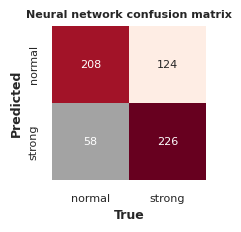

In [41]:
plot_cfm(y_test, y_pred_test, title="Neural network confusion matrix", cmap=CMAP_CFM)

In [42]:
net.model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               23200     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 43,501
Trainable params: 43,501
Non-trainable params: 0
_________________________________________________________________


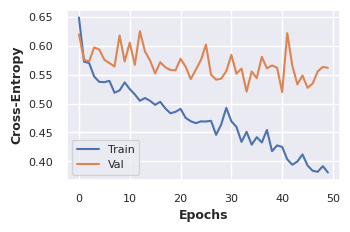

In [43]:
history = net.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

200/200 [==============================] - 0s 2ms/step


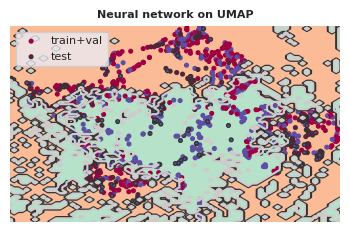

In [44]:
boundaries_on_embedding(reducer, net, embedding=embedding, 
                        n_pts=N_PTS,
                       cmap=CMAP,
                       title=f"Neural network on {embedding_name}")

# Ensemble methods

## Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [46]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 2000, 10)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',['auto', 'sqrt'])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               bootstrap=bootstrap, criterion=criterion)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-09 12:49:27,563] A new study created in memory with name: no-name-8ec48eb8-a772-48c8-a7af-9ec63da28e60
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2023-07-09 12:49:54,802] Trial 0 finished with value: 0.7245179063360881 and parameters: {'n_estimators': 1060, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 9, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 0 with value: 0.7245179063360881.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.

[W 2023-07-09 12:51:45,328] Trial 16 failed with value None.
[I 2023-07-09 12:51:50,497] Trial 13 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 1090, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 12 with value: 0.7465564738292011.
[I 2023-07-09 12:51:51,969] Trial 11 finished with value: 0.7300275482093664 and parameters: {'n_estimators': 1530, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 12 with value: 0.7465564738292011.
[I 2023-07-09 12:51:56,296] Trial 15 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 210, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 12 with value: 0.7465564738292011.
[I 2023-07-09 12:51:58,383] Trial 17 finished w

[W 2023-07-09 12:53:25,087] Trial 31 failed with value None.
[I 2023-07-09 12:53:32,521] Trial 27 finished with value: 0.7410468319559229 and parameters: {'n_estimators': 790, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 23 with value: 0.7493112947658402.
[I 2023-07-09 12:53:34,961] Trial 28 finished with value: 0.7410468319559229 and parameters: {'n_estimators': 800, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 23 with value: 0.7493112947658402.
[I 2023-07-09 12:53:36,726] Trial 29 finished with value: 0.7327823691460055 and parameters: {'n_estimators': 830, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 6, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 23 with value: 0.7493112947658402.
[W 2023-07-09 12:53:36,797] Trial 35 failed w

[W 2023-07-09 12:54:01,597] Trial 40 failed with value None.
[W 2023-07-09 12:54:01,672] Trial 41 failed with parameters: {'n_estimators': 360, 'max_depth': 70, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 2, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'min_samples_split' parameter of RandomForestClassifier must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got 1 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtuale

[W 2023-07-09 12:54:18,474] Trial 48 failed with value None.
[W 2023-07-09 12:54:18,550] Trial 49 failed with parameters: {'n_estimators': 930, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 10, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'min_samples_split' parameter of RandomForestClassifier must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got 1 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtual

In [47]:
best_params = study.best_params

rf = RandomForestClassifier(**best_params)
rf.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = rf.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 700, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       332
           1       0.72      0.70      0.71       284

    accuracy                           0.74       616
   macro avg       0.74      0.73      0.73       616
weighted avg       0.74      0.74      0.74       616

Accuracy 0.737012987012987
F1-score [0.75964392 0.70967742]


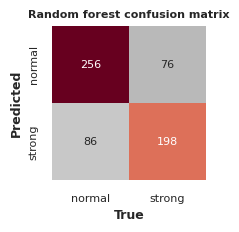

In [48]:
plot_cfm(y_test, y_pred_test, title="Random forest confusion matrix", cmap=CMAP_CFM)

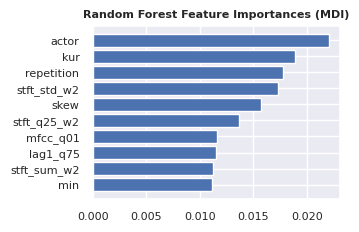

In [49]:
nbr_features = X_train.shape[1]

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[::-1][:10]
df2 = df.iloc[:, sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx][::-1])
plt.yticks(y_ticks, list(df2.columns)[::-1])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

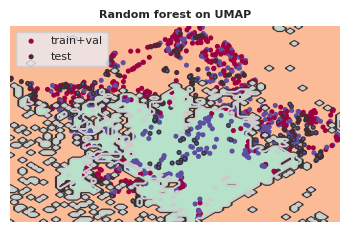

In [50]:
boundaries_on_embedding(reducer, rf, embedding=embedding,
                       cmap=CMAP,
                       n_pts=N_PTS,
                        title=f"Random forest on {embedding_name}")

In [51]:
from sklearn.inspection import permutation_importance

In [52]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

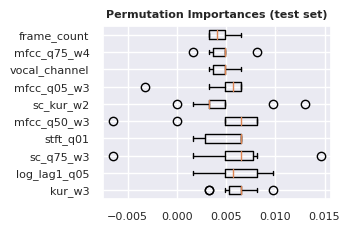

In [53]:
sorted_idx = result.importances_mean.argsort()[::-1][:10]
df2 = df.iloc[:, sorted_idx]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=list(df2.columns)[::-1])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [54]:
from sklearn.tree import plot_tree

In [55]:
rf.estimators_[0]

DecisionTreeClassifier(criterion='entropy', max_depth=80, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=7,
                       random_state=48081059)

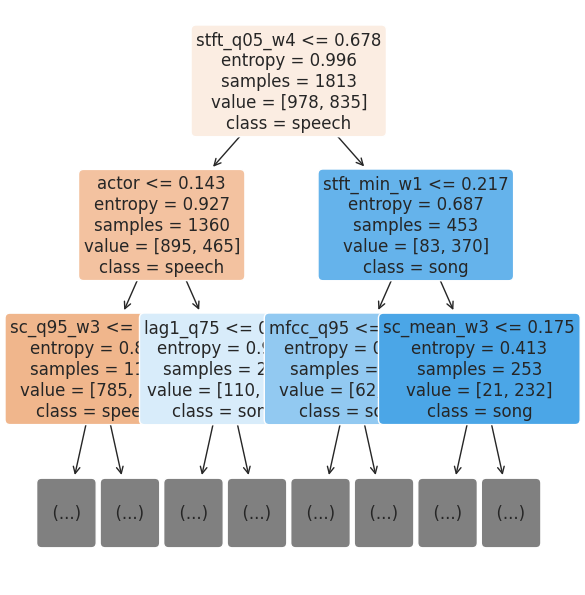

In [56]:
plt.figure(figsize=(6,6))
plot_tree(rf.estimators_[0], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

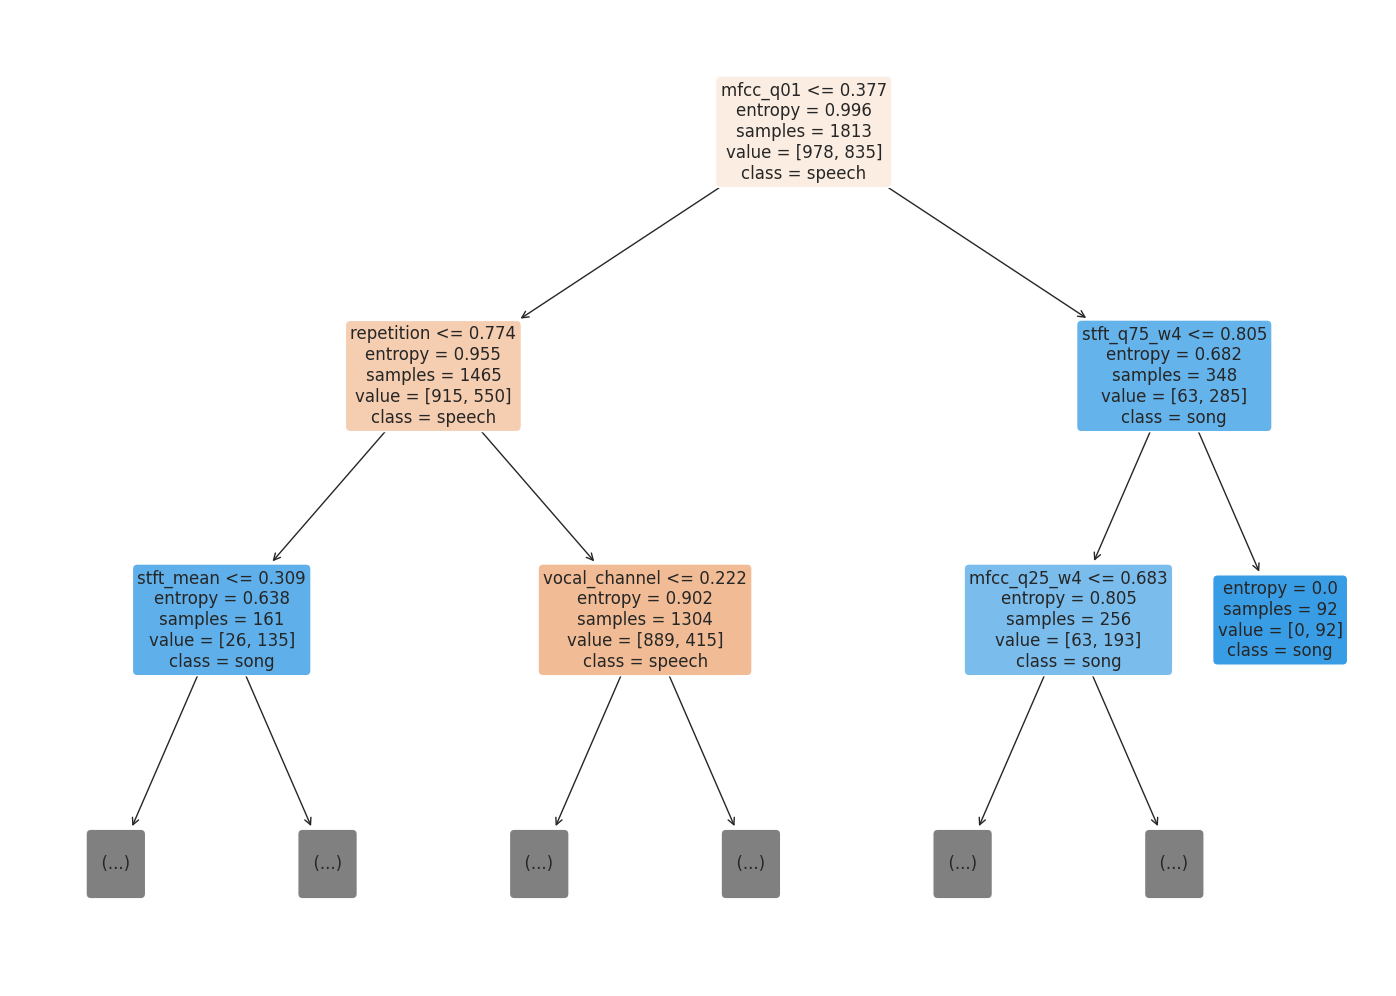

In [57]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[1], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

# Gradient Boosting

In [58]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [59]:
from sklearn.metrics import class_likelihood_ratios
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 1, 20)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',["log2","sqrt"])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    criterion = trial.suggest_categorical('criterion', ["friedman_mse",  "mae"])
    subsample = trial.suggest_float('subsample', 0.5, 1)
    loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
                                  
                                          
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               learning_rate=learning_rate, criterion=criterion, subsample=subsample, loss=loss)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_val)
    error = accuracy_score(y_val, y_pred)
    L_pos, L_neg = class_likelihood_ratios(y_val, y_pred)

    return L_pos#error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 200, n_jobs = -1, catch=(ValueError,))

[I 2023-07-09 13:06:53,807] A new study created in memory with name: no-name-f8c649ef-1e48-4e06-909c-0bb6fb2dd289
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
[W 2023-07-09 13:06:53,863] Trial 2 failed with parameters: {'n_estimators': 1, 'max_depth': 90, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 5, 'learning_rate': 0.09697892225622241, 'criterion': 'mae', 'subsample': 0.7825478104661345, 'loss': 'deviance'} because of the fo

[W 2023-07-09 13:06:54,660] Trial 9 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
[I 2023-07-09 13:06:54,835] Trial 1 finished with value: 2.9893982380170225 and parameters: {'n_estimators': 10, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 2, 'learning_rate': 0.15971218714031465, 'criterion': 'friedman_mse', 'subsample': 0.9362204655205348, 'loss': 'deviance'}. Best is trial 4 with value: 3.6353591160220993.
[I 2023-07-09 13:06:55,043] Trial 7 finished with value: 3.873132801309597 and parameters: {'n_estimators': 13, 'max_depth': 60, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 5, 'learning_rate': 0.05548757465411603, 'criterion': 'friedman_mse', 'subsam

[W 2023-07-09 13:06:55,438] Trial 17 failed with value None.
[W 2023-07-09 13:06:55,450] Trial 18 failed with parameters: {'n_estimators': 2, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 9, 'learning_rate': 0.2859622989012875, 'criterion': 'mae', 'subsample': 0.5963282761807855, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-07-09 13:06:56,039] Trial 24 failed with value None.
[I 2023-07-09 13:06:56,261] Trial 15 finished with value: 3.3155144094370614 and parameters: {'n_estimators': 11, 'max_depth': 40, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 4, 'learning_rate': 0.20321221071529066, 'criterion': 'friedman_mse', 'subsample': 0.8757997854948143, 'loss': 'deviance'}. Best is trial 7 with value: 3.873132801309597.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
[I 2023-07-09 13:06:56,296] Trial 19 finished with value: 2.9636522244838615 and parameters: {'n_estimators': 8, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 3, 'learning_rate': 0.21809510343189054, 'criterion': 'friedman_mse', 'subs

[W 2023-07-09 13:06:56,888] Trial 31 failed with value None.
[W 2023-07-09 13:06:56,959] Trial 32 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 8, 'learning_rate': 0.02191207375175884, 'criterion': 'mae', 'subsample': 0.9893547789615516, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-07-09 13:06:57,387] Trial 37 failed with value None.
[W 2023-07-09 13:06:57,468] Trial 38 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 8, 'learning_rate': 0.04123572661385971, 'criterion': 'mae', 'subsample': 0.9939902291005422, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-07-09 13:06:57,962] Trial 43 failed with value None.
[W 2023-07-09 13:06:58,041] Trial 44 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 8, 'learning_rate': 0.024536503932436865, 'criterion': 'mae', 'subsample': 0.9441850734299059, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 13:06:58,470] Trial 49 failed with value None.
[W 2023-07-09 13:06:58,544] Trial 50 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 8, 'learning_rate': 0.019696518126210885, 'criterion': 'mae', 'subsample': 0.8194344760367137, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 13:06:59,032] Trial 54 failed with parameters: {'n_estimators': 19, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 5, 'learning_rate': 0.08289478024685809, 'criterion': 'mae', 'subsample': 0.7717503752326741, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/

[W 2023-07-09 13:06:59,516] Trial 60 failed with value None.
[W 2023-07-09 13:06:59,518] Trial 59 failed with value None.
[W 2023-07-09 13:06:59,681] Trial 62 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 5, 'learning_rate': 0.07787890142075574, 'criterion': 'mae', 'subsample': 0.7537468020713471, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/e

[W 2023-07-09 13:07:00,152] Trial 66 failed with parameters: {'n_estimators': 19, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 5, 'learning_rate': 0.08698594029127871, 'criterion': 'mae', 'subsample': 0.9993021543440866, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/

[W 2023-07-09 13:07:00,473] Trial 69 failed with value None.
[W 2023-07-09 13:07:00,476] Trial 71 failed with value None.
[W 2023-07-09 13:07:00,482] Trial 70 failed with value None.
[W 2023-07-09 13:07:00,659] Trial 74 failed with parameters: {'n_estimators': 18, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 5, 'learning_rate': 0.08320855758860525, 'criterion': 'mae', 'subsample': 0.7286795942182406, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/vi

[W 2023-07-09 13:07:01,118] Trial 78 failed with value None.
[W 2023-07-09 13:07:01,136] Trial 77 failed with parameters: {'n_estimators': 19, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 5, 'learning_rate': 0.08253922467914317, 'criterion': 'mae', 'subsample': 0.7627388213959, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  

[W 2023-07-09 13:07:01,666] Trial 82 failed with value None.
[W 2023-07-09 13:07:01,682] Trial 84 failed with value None.
[W 2023-07-09 13:07:01,686] Trial 83 failed with parameters: {'n_estimators': 19, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 5, 'learning_rate': 0.0818898222110194, 'criterion': 'mae', 'subsample': 0.757121088679715, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ens

[W 2023-07-09 13:07:02,270] Trial 89 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 5, 'learning_rate': 0.0752731886070257, 'criterion': 'mae', 'subsample': 0.7521420521913774, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/l

[W 2023-07-09 13:07:02,768] Trial 95 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 6, 'learning_rate': 0.08529834142228992, 'criterion': 'mae', 'subsample': 0.9797808304664437, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/

[W 2023-07-09 13:07:03,197] Trial 100 failed with value None.
[W 2023-07-09 13:07:03,212] Trial 102 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 6, 'learning_rate': 0.08748914954782971, 'criterion': 'mae', 'subsample': 0.6682004887177895, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 13:07:03,713] Trial 107 failed with value None.
[W 2023-07-09 13:07:03,752] Trial 108 failed with parameters: {'n_estimators': 19, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 6, 'learning_rate': 0.08641165335785292, 'criterion': 'mae', 'subsample': 0.9807782643053555, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 13:07:04,142] Trial 113 failed with value None.
[W 2023-07-09 13:07:04,212] Trial 114 failed with parameters: {'n_estimators': 19, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 6, 'learning_rate': 0.08760563396560252, 'criterion': 'mae', 'subsample': 0.6545549179807224, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 13:07:04,529] Trial 118 failed with value None.
[W 2023-07-09 13:07:04,583] Trial 119 failed with value None.
[W 2023-07-09 13:07:04,783] Trial 121 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 6, 'learning_rate': 0.08286414758446746, 'criterion': 'mae', 'subsample': 0.6814570296134379, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklear

[W 2023-07-09 13:07:05,260] Trial 124 failed with value None.
[W 2023-07-09 13:07:05,263] Trial 126 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 6, 'learning_rate': 0.08461132851764301, 'criterion': 'mae', 'subsample': 0.9799727016995841, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 13:07:05,698] Trial 133 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 6, 'learning_rate': 0.08479585533737763, 'criterion': 'mae', 'subsample': 0.6845652046427447, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa

[W 2023-07-09 13:07:06,099] Trial 137 failed with value None.
[W 2023-07-09 13:07:06,220] Trial 138 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 6, 'learning_rate': 0.08998254496561711, 'criterion': 'mae', 'subsample': 0.6468909999090866, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 13:07:06,786] Trial 145 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 6, 'learning_rate': 0.08177187158375192, 'criterion': 'mae', 'subsample': 0.9835305445467968, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa

[W 2023-07-09 13:07:07,107] Trial 149 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 6, 'learning_rate': 0.08570459514859441, 'criterion': 'mae', 'subsample': 0.6927953251408525, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa

[W 2023-07-09 13:07:07,734] Trial 156 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 6, 'learning_rate': 0.10064933646543567, 'criterion': 'mae', 'subsample': 0.9961909685613861, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa

[W 2023-07-09 13:07:08,038] Trial 160 failed with value None.
[W 2023-07-09 13:07:08,075] Trial 161 failed with value None.
[W 2023-07-09 13:07:08,100] Trial 162 failed with parameters: {'n_estimators': 19, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 6, 'learning_rate': 0.08791582853984045, 'criterion': 'mae', 'subsample': 0.9935279984883334, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklear

[W 2023-07-09 13:07:08,519] Trial 166 failed with value None.
[W 2023-07-09 13:07:08,592] Trial 168 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 6, 'learning_rate': 0.08427095180466376, 'criterion': 'mae', 'subsample': 0.6696674230324121, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 13:07:09,019] Trial 174 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 6, 'learning_rate': 0.06530222476433206, 'criterion': 'mae', 'subsample': 0.9896971155977188, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa

[W 2023-07-09 13:07:09,482] Trial 176 failed with value None.
[W 2023-07-09 13:07:09,494] Trial 179 failed with value None.
[W 2023-07-09 13:07:09,751] Trial 180 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 6, 'learning_rate': 0.08250449162085914, 'criterion': 'mae', 'subsample': 0.9880602686962325, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklear

[W 2023-07-09 13:07:10,141] Trial 184 failed with value None.
[W 2023-07-09 13:07:10,143] Trial 185 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 6, 'learning_rate': 0.08286002589940203, 'criterion': 'mae', 'subsample': 0.6624724766386577, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 13:07:10,627] Trial 189 failed with value None.
[W 2023-07-09 13:07:10,629] Trial 192 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 6, 'learning_rate': 0.08355462127226582, 'criterion': 'mae', 'subsample': 0.6538792613179019, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 13:07:11,171] Trial 196 failed with value None.
[W 2023-07-09 13:07:11,267] Trial 198 failed with parameters: {'n_estimators': 20, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 6, 'learning_rate': 0.08290926798651653, 'criterion': 'mae', 'subsample': 0.674746024901957, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_153458/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

In [60]:
best_params = study.best_params

gb = GradientBoostingClassifier(**best_params)
gb.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = gb.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 13, 'max_depth': 60, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 5, 'learning_rate': 0.05548757465411603, 'criterion': 'friedman_mse', 'subsample': 0.8085979636830781, 'loss': 'log_loss'}
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       332
           1       0.72      0.62      0.67       284

    accuracy                           0.71       616
   macro avg       0.71      0.71      0.71       616
weighted avg       0.71      0.71      0.71       616

Accuracy 0.7126623376623377
F1-score [0.74822191 0.66540643]


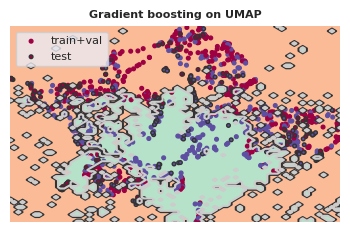

In [61]:
boundaries_on_embedding(reducer, gb, embedding=embedding,
                       cmap=CMAP,
                       n_pts=N_PTS,
                       title=f"Gradient boosting on {embedding_name}")

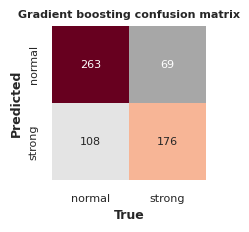

In [62]:
plot_cfm(y_test, y_pred_test, title="Gradient boosting confusion matrix", cmap=CMAP_CFM)